In [1]:
from getpass import getuser # Libaray to copy things
from tempfile import NamedTemporaryFile, TemporaryDirectory 

import dask

from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu // threads
print(
    f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}"
)
client = Client(
    processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit="100GB"
)
client 

# calculation
import metpy.calc as mpcalc

# scipy
from scipy import stats
from scipy.ndimage import measurements
from scipy import ndimage
from scipy.optimize import curve_fit

# for plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# basic
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import netCDF4 as nc
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data

# dask
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

Number of CPUs: 256, number of threads: 8, number of workers: 32


2024-07-11 08:16:56,858 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-2uo8_s5x', purging
2024-07-11 08:16:56,878 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-y1dl2nhe', purging
2024-07-11 08:16:56,908 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-vznbr_nu', purging
2024-07-11 08:16:56,918 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-kjauigke', purging
2024-07-11 08:16:56,927 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Project2/dask-worker-space/worker-rxduuifl', purging
2024-07-11 08:16:56,982 - distributed.diskutils - INFO - Found stale lock file and directory '/home/m/m300948/ICON_AMZDEF/Pro

In [2]:
import sys
sys.path.append('/home/m/m300948/ICON_AMZDEF')
import Tools

Number of CPUs: 256, number of threads: 8, number of workers: 32


# Load data

In [3]:
pr_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/pr/ctl_daily_pr_202*',parallel=True)['pr']
pr_def = xr.open_mfdataset('/scratch/m/m300948/def_100/pr/def_daily_pr_202*',parallel=True)['pr']

_check rainy days_

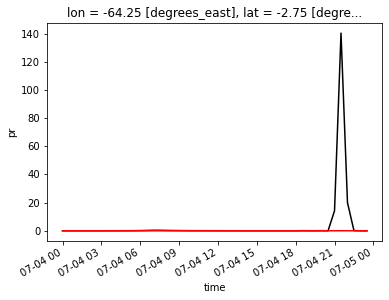

In [9]:
(pr_ctl.sel(time=slice('2022-07-04', '2022-07-04'),lat=-2.75, lon=-64.25)*3600*24).plot(c='black')
(pr_def.sel(time=slice('2022-07-04', '2022-07-04'),lat=-2.75, lon=-64.25)*3600*24).plot(c='red')

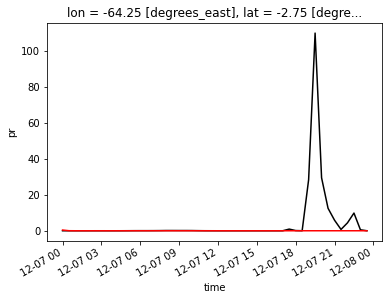

In [64]:
(pr_ctl.sel(time=slice('2022-12-07', '2022-12-07'),lat=-2.75, lon=-64.25)*3600*24).plot(c='black')
(pr_def.sel(time=slice('2022-12-07', '2022-12-07'),lat=-2.75, lon=-64.25)*3600*24).plot(c='red')

In [66]:
import xarray as xr

a = pr_ctl.sel(time=slice('2022-12-07', '2022-12-07'), lat=-2.75, lon=-64.25)*3600*24
# Create a boolean mask where values exceed 0.1
mask = a > 0.1

# Select the time coordinates where the mask is True
dates_with_values_above_0_1 = a['time'][mask].values

print("Dates with values above 0.1:", dates_with_values_above_0_1)


Dates with values above 0.1: ['2022-12-07T08:00:00.000000000' '2022-12-07T08:30:00.000000000'
 '2022-12-07T09:00:00.000000000' '2022-12-07T09:30:00.000000000'
 '2022-12-07T10:00:00.000000000' '2022-12-07T17:30:00.000000000'
 '2022-12-07T18:00:00.000000000' '2022-12-07T19:00:00.000000000'
 '2022-12-07T19:30:00.000000000' '2022-12-07T20:00:00.000000000'
 '2022-12-07T20:30:00.000000000' '2022-12-07T21:00:00.000000000'
 '2022-12-07T21:30:00.000000000' '2022-12-07T22:00:00.000000000'
 '2022-12-07T22:30:00.000000000' '2022-12-07T23:00:00.000000000']


In [67]:
import xarray as xr

a = pr_def.sel(time=slice('2022-12-07', '2022-12-07'), lat=-2.75, lon=-64.25)*3600*24
# Create a boolean mask where values exceed 0.1
mask = a > 0.1

# Select the time coordinates where the mask is True
dates_with_values_above_0_1 = a['time'][mask].values

print("Dates with values above 0.1:", dates_with_values_above_0_1)

Dates with values above 0.1: ['2022-12-07T00:00:00.000000000']


# Masking

_Amazon basin masking_

In [4]:
dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
AMZ_BD = dset_bd.AMAZON_BIOMES

In [5]:
ABinterp_biome = AMZ_BD.interp(latitude=pr_ctl.lat, longitude=pr_ctl.lon)

In [6]:
pr_ctl_mask = pr_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

In [7]:
pr_def_mask = pr_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

# Converting into Hourly and Daily data

**Unit inversion - hour**

In [8]:
# masked - make 6 hourly data to daily data
pr_ctl_hour_mask = pr_ctl_mask.resample(time='H').mean()
pr_def_hour_mask = pr_def_mask.resample(time='H').mean()

In [9]:
# masked - make the unit into mm/hour
pr_ctl_mm_hour_mask = (pr_ctl_hour_mask*3600).compute()
pr_def_mm_hour_mask = (pr_def_hour_mask*3600).compute()

**Unit inversion - month**

In [10]:
# masked - make 6 hourly data to daily data
pr_ctl_mon_mask = pr_ctl_mask.resample(time='D').mean()
pr_def_mon_mask = pr_def_mask.resample(time='D').mean()

In [11]:
# masked - make the unit into mm/mon
pr_ctl_mm_mon_mask = (pr_ctl_mon_mask*3600*24).compute()
pr_def_mm_mon_mask = (pr_def_mon_mask*3600*24).compute()

# Divide months

## All years together

In [11]:
# select only wet and dry season
pr_ctl_mm_hour_mask = pr_ctl_mm_hour_mask.sel(time=pr_ctl_mm_hour_mask.time.dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]))
pr_def_mm_hour_mask = pr_def_mm_hour_mask.sel(time=pr_def_mm_hour_mask.time.dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]))

In [12]:
# hourly, all years into each month
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

for name in xarray_names:
    xarray_data = globals()[name]
    for i in np.arange(1,13):
        xarray_data_mon = xarray_data.where(xarray_data.time.dt.month.isin([i]), drop=True)
        new_name = name + '_' + mon_names[i-1] 
        globals()[new_name] = xarray_data_mon

In [13]:
# hourly, all years and each month
 
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

suffix = '_above1'

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] 
        xarray_data = globals()[dset_name]
        xarray_data_abov1 = xarray_data.where(xarray_data >= 0.1)
        
        new_name = dset_name + suffix
        globals()[new_name] = xarray_data_abov1

In [14]:
# hourly, all years and each month
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']
suffix = '_above1'

for name in xarray_names:
    dset_name = name 
    xarray_data = globals()[dset_name]
    xarray_data_abov1 = xarray_data.where(xarray_data >= 0.1)
    
    new_name = dset_name + suffix
    globals()[new_name] = xarray_data_abov1

## Each year individually

In [12]:
# CTL hourly data
pr_ctl_mm_hour_mask_2020 = pr_ctl_mm_hour_mask.sel(time=slice('2020-01-01','2020-12-31'))
pr_ctl_mm_hour_mask_2021 = pr_ctl_mm_hour_mask.sel(time=slice('2021-01-01','2021-12-31'))
pr_ctl_mm_hour_mask_2022 = pr_ctl_mm_hour_mask.sel(time=slice('2022-01-01','2022-12-31'))

In [13]:
# DEF hourly data
pr_def_mm_hour_mask_2020 = pr_def_mm_hour_mask.sel(time=slice('2020-01-01','2020-12-31'))
pr_def_mm_hour_mask_2021 = pr_def_mm_hour_mask.sel(time=slice('2021-01-01','2021-12-31'))
pr_def_mm_hour_mask_2022 = pr_def_mm_hour_mask.sel(time=slice('2022-01-01','2022-12-31'))

In [17]:
# CTL hourly data
pr_ctl_mm_hour_mask_above1_2020 = pr_ctl_mm_hour_mask_above1.sel(time=slice('2020-01-01','2020-12-31'))
pr_ctl_mm_hour_mask_above1_2021 = pr_ctl_mm_hour_mask_above1.sel(time=slice('2021-01-01','2021-12-31'))
pr_ctl_mm_hour_mask_above1_2022 = pr_ctl_mm_hour_mask_above1.sel(time=slice('2022-01-01','2022-12-31'))

In [18]:
# CTL hourly data
pr_def_mm_hour_mask_above1_2020 = pr_def_mm_hour_mask_above1.sel(time=slice('2020-01-01','2020-12-31'))
pr_def_mm_hour_mask_above1_2021 = pr_def_mm_hour_mask_above1.sel(time=slice('2021-01-01','2021-12-31'))
pr_def_mm_hour_mask_above1_2022 = pr_def_mm_hour_mask_above1.sel(time=slice('2022-01-01','2022-12-31'))

In [19]:
# Separate the data into 2020, 2021, 2022 
## hour
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask_2020','pr_ctl_mm_hour_mask_2021','pr_ctl_mm_hour_mask_2022',
                'pr_def_mm_hour_mask_2020','pr_def_mm_hour_mask_2021','pr_def_mm_hour_mask_2022']

for name in xarray_names:
    xarray_data = globals()[name]
    for i in np.arange(1,13):
        xarray_data_mon = xarray_data.where(xarray_data.time.dt.month.isin([i]), drop=True)
        new_name = name + '_' + mon_names[i-1] 
        globals()[new_name] = xarray_data_mon

# flatten the data - one value from the domain

## All years

In [16]:
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [22]:
xarray_names = ['pr_ctl_mm_mon_mask','pr_def_mm_mon_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [21]:
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']
new_suffix = '_f'

for name in xarray_names:
    dset_name = name + '_above1'
    xarray_data = globals()[dset_name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_f

In [22]:
# hourly, all years and each month
 
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

suffix = '_f'

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] 
        xarray_data = globals()[dset_name]
        xarray_data_flat = xarray_data.values.flatten()
        xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
        
        new_name = dset_name + suffix
        globals()[new_name] = xarray_data_f

In [23]:
# hourly, all years and each month
 
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

suffix = '_f'

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] + '_above1'
        xarray_data = globals()[dset_name]
        xarray_data_flat = xarray_data.values.flatten()
        xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
        
        new_name = dset_name + suffix
        globals()[new_name] = xarray_data_f

## Each year individually

In [14]:
# years
new_suffix = '_f'

xarray_names = ['pr_ctl_mm_hour_mask_2020','pr_ctl_mm_hour_mask_2021','pr_ctl_mm_hour_mask_2022',
                'pr_def_mm_hour_mask_2020','pr_def_mm_hour_mask_2021','pr_def_mm_hour_mask_2022']

for name in xarray_names:
    dset_name = name 
    xarray_data = globals()[dset_name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_f

In [25]:
# years
new_suffix = '_f'

xarray_names = ['pr_ctl_mm_hour_mask_above1_2020','pr_ctl_mm_hour_mask_above1_2021','pr_ctl_mm_hour_mask_above1_2022',
                'pr_def_mm_hour_mask_above1_2020','pr_def_mm_hour_mask_above1_2021','pr_def_mm_hour_mask_above1_2022']

for name in xarray_names:
    dset_name = name 
    xarray_data = globals()[dset_name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_f

In [26]:
# year and months
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
new_suffix = '_f'

xarray_names = ['pr_ctl_mm_hour_mask_2020','pr_ctl_mm_hour_mask_2021','pr_ctl_mm_hour_mask_2022',
                'pr_def_mm_hour_mask_2020','pr_def_mm_hour_mask_2021','pr_def_mm_hour_mask_2022']

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] 
        xarray_data = globals()[dset_name]
        xarray_data_flat = xarray_data.values.flatten()
        xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
        new_name = dset_name + new_suffix
        globals()[new_name] = xarray_data_f

# find the quantile99

## All years

In [17]:
xarray_names = ['pr_ctl_mm_hour_mask_f','pr_def_mm_hour_mask_f']
new_suffix = '_q99'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)
    
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_q99

In [23]:
xarray_names = ['pr_ctl_mm_mon_mask_f','pr_def_mm_mon_mask_f']
new_suffix = '_q99'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)
    
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_q99

In [28]:
xarray_names = ['pr_ctl_mm_hour_mask_above1_f','pr_def_mm_hour_mask_above1_f']
new_suffix = '_q99'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)
    
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_q99

In [32]:
print(pr_ctl_mm_hour_mask_f_q99, pr_def_mm_hour_mask_f_q99)
print(pr_ctl_mm_hour_mask_above1_f_q99, pr_def_mm_hour_mask_above1_f_q99)

7.8595071649551755 7.5539679527282715
30.888481903076126 34.15446662902832


In [24]:
print(pr_ctl_mm_mon_mask_f_q99, pr_def_mm_mon_mask_f_q99)

62.17449951171875 70.54706840515126


In [29]:
# hourly, all years and each month
 
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

suffix = '_q99'

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] + '_f'
        #dset_name = name + '_' + mon_names[i-1] + '_f'
        xarray_data = globals()[dset_name]
        xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)
        
        new_name = dset_name + suffix
        globals()[new_name] = xarray_data_q99

In [39]:
print(pr_ctl_mm_hour_mask_jan_f_q99, pr_ctl_mm_hour_mask_feb_f_q99, pr_ctl_mm_hour_mask_mar_f_q99)
print(pr_ctl_mm_hour_mask_apr_f_q99, pr_ctl_mm_hour_mask_may_f_q99, pr_ctl_mm_hour_mask_jun_f_q99)
print(pr_ctl_mm_hour_mask_jul_f_q99,pr_ctl_mm_hour_mask_aug_f_q99,pr_ctl_mm_hour_mask_sep_f_q99,pr_ctl_mm_hour_mask_dec_f_q99)

9.921536312103285 9.994010725021298 10.493810443878147
9.233874320983887 6.760553784370423 6.081274476051327
4.731624279022071 4.86936042308804 5.874236512184133 9.343930759429924


In [40]:
print(pr_def_mm_hour_mask_jan_f_q99, pr_def_mm_hour_mask_feb_f_q99, pr_def_mm_hour_mask_mar_f_q99)
print(pr_def_mm_hour_mask_apr_f_q99, pr_def_mm_hour_mask_may_f_q99, pr_def_mm_hour_mask_jun_f_q99)
print(pr_def_mm_hour_mask_jul_f_q99,pr_def_mm_hour_mask_aug_f_q99,pr_def_mm_hour_mask_sep_f_q99,pr_def_mm_hour_mask_dec_f_q99)

9.452934160232573 9.578183927535946 10.337903547287041
9.704271898269653 7.407729654312121 5.872163262367231
4.319746036529523 3.456812038421617 4.950095434188839 9.493036203384364


In [31]:
# hourly, all years and each month
 
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

suffix = '_q99'

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] + '_above1_f'
        #dset_name = name + '_' + mon_names[i-1] + '_f'
        xarray_data = globals()[dset_name]
        xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)
        
        new_name = dset_name + suffix
        globals()[new_name] = xarray_data_q99

In [41]:
print(pr_ctl_mm_hour_mask_jan_above1_f_q99, pr_ctl_mm_hour_mask_feb_above1_f_q99, pr_ctl_mm_hour_mask_mar_above1_f_q99)
print(pr_ctl_mm_hour_mask_apr_above1_f_q99, pr_ctl_mm_hour_mask_may_above1_f_q99, pr_ctl_mm_hour_mask_jun_above1_f_q99)
print(pr_ctl_mm_hour_mask_jul_above1_f_q99,pr_ctl_mm_hour_mask_aug_above1_f_q99,pr_ctl_mm_hour_mask_sep_above1_f_q99,pr_ctl_mm_hour_mask_dec_above1_f_q99)

30.371661682128902 31.051439132690412 31.936634826660175
30.721728534698475 27.414490585327144 26.56921728134153
26.517975940704343 29.67175354003908 33.155416221618594 31.452776107788054


In [42]:
print(pr_def_mm_hour_mask_jan_above1_f_q99, pr_def_mm_hour_mask_feb_above1_f_q99, pr_def_mm_hour_mask_mar_above1_f_q99)
print(pr_def_mm_hour_mask_apr_above1_f_q99, pr_def_mm_hour_mask_may_above1_f_q99, pr_def_mm_hour_mask_jun_above1_f_q99)
print(pr_def_mm_hour_mask_jul_above1_f_q99,pr_def_mm_hour_mask_aug_above1_f_q99,pr_def_mm_hour_mask_sep_above1_f_q99,pr_def_mm_hour_mask_dec_above1_f_q99)

32.898582458496264 34.23654067993175 35.74760963439937
35.32425140380846 32.5269044876098 30.53921661376951
31.13716697692871 30.84107856750488 34.19301319122312 34.33496353149414


## Each year individually

In [29]:
# year/month separation
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
new_suffix = '_q99'

xarray_names = ['pr_ctl_mm_hour_mask_2020','pr_ctl_mm_hour_mask_2021','pr_ctl_mm_hour_mask_2022',
                'pr_def_mm_hour_mask_2020','pr_def_mm_hour_mask_2021','pr_def_mm_hour_mask_2022']

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] + '_f'
        xarray_data = globals()[dset_name]
        xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)
    
        new_name = dset_name + new_suffix
        globals()[new_name] = xarray_data_q99

In [42]:
# year/month separation
new_suffix = '_q99'

xarray_names = ['pr_ctl_mm_hour_mask_2020','pr_ctl_mm_hour_mask_2021','pr_ctl_mm_hour_mask_2022',
                'pr_def_mm_hour_mask_2020','pr_def_mm_hour_mask_2021','pr_def_mm_hour_mask_2022']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [43]:
print(pr_ctl_mm_hour_mask_2020_f_q99,pr_ctl_mm_hour_mask_2021_f_q99,pr_ctl_mm_hour_mask_2022_f_q99,
      pr_def_mm_hour_mask_2020_f_q99,pr_def_mm_hour_mask_2021_f_q99,pr_def_mm_hour_mask_2022_f_q99)

7.255847930908203 7.503037977218639 7.551352529525758 6.211879291534444 7.197877469062817 7.184041700363167


In [44]:
# year/month separation
new_suffix = '_q99'

xarray_names = ['pr_ctl_mm_hour_mask_above1_2020','pr_ctl_mm_hour_mask_above1_2021','pr_ctl_mm_hour_mask_above1_2022',
                'pr_def_mm_hour_mask_above1_2020','pr_def_mm_hour_mask_above1_2021','pr_def_mm_hour_mask_above1_2022']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [45]:
print(pr_ctl_mm_hour_mask_above1_2020_f_q99,pr_ctl_mm_hour_mask_above1_2021_f_q99,pr_ctl_mm_hour_mask_above1_2022_f_q99,
      pr_def_mm_hour_mask_above1_2020_f_q99,pr_def_mm_hour_mask_above1_2021_f_q99,pr_def_mm_hour_mask_above1_2022_f_q99)

30.739758033752445 30.586798248291004 30.454808712005615 33.08387344360351 33.218025360107504 33.523941040039176


# Plotting

In [27]:
def plot_pdf(data_ctl, data_def, bins, label_ctl, label_def, linecolor_1, linecolor_2, title, xlim, p99_1, p99_2):
    pdf_ctl, bins_ctl = np.histogram(data_ctl, bins=bins, density=True)  # Adjust the number of bins as needed
    pdf_def, bins_def = np.histogram(data_def, bins=bins, density=True)

    # Calculate the bin centers
    bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
    bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2
    
    # Calculate the bin width
    bin_width_ctl = np.diff(bins_ctl)
    bin_width_def = np.diff(bins_def)
    
    # Normalize the PDF
    pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum()*bin_width_ctl
    pdf_normalized_def = pdf_def / pdf_def.sum()*bin_width_def
    
    # Plot the PDF
    fig = plt.figure(figsize=(8, 6))
    plt.plot(bin_centers_ctl, pdf_normalized_ctl, label=label_ctl, color=linecolor_1, linewidth=2.5)
    plt.plot(bin_centers_def, pdf_normalized_def, label=label_def, color=linecolor_2, linewidth=2.5)

    # Set labels and title
    plt.xlabel('mm/day', fontsize='25')
    plt.ylabel('Probability Density (log)', fontsize='25')
    #plt.title('PDF', fontsize='15')
    plt.yscale('log')
    plt.xlim(0, xlim)
    plt.xticks(fontsize='25')
    plt.yticks(fontsize='25')


    # plot p99
    plt.axvline(p99_1, color='black', ls=':')
    plt.axvline(p99_2, color='red', ls=':')

    # add legend
    #plt.legend()

    # Display the plot
    plt.show()

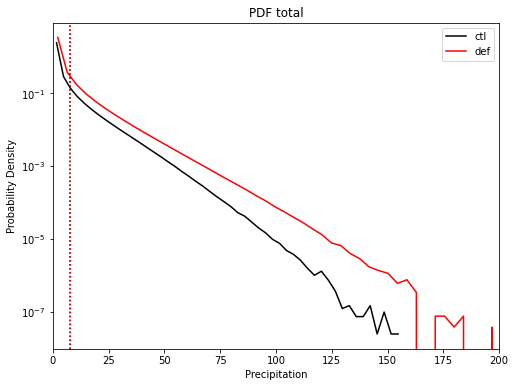

In [39]:
plot_pdf(pr_ctl_mm_hour_mask_above1_f, pr_def_mm_hour_mask_above1_f, 50, 'ctl', 'def', 'black', 'red', 'PDF total', 200, pr_ctl_mm_hour_mask_f_q99, pr_def_mm_hour_mask_f_q99)

In [14]:
print(pr_ctl_mm_mon_mask_f_q99, pr_def_mm_mon_mask_f_q99)

62.17449951171875 70.54706840515126


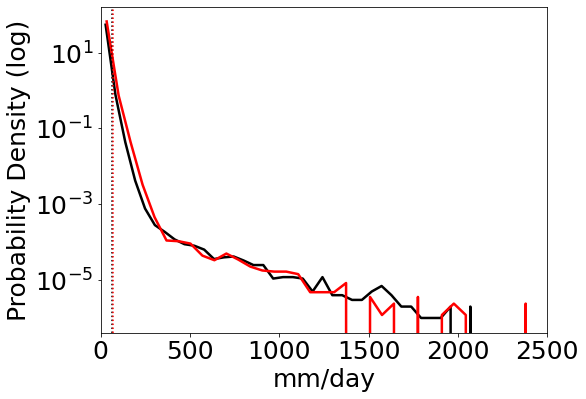

In [28]:
plot_pdf(pr_ctl_mm_mon_mask_f, pr_def_mm_mon_mask_f, 50, 'ctl', 'def', 'black', 'red', 'PDF total', 2500, pr_ctl_mm_mon_mask_f_q99, pr_def_mm_mon_mask_f_q99)

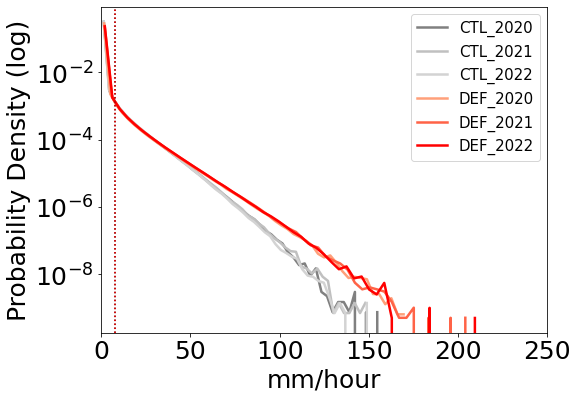

In [29]:
# Normalize the PDF
pdf_ctl_2020, bins_ctl_2020 = np.histogram(pr_ctl_mm_hour_mask_2020_f, bins=50, density=True)  # Adjust the number of bins as needed (hist, bins)
pdf_def_2020, bins_def_2020 = np.histogram(pr_def_mm_hour_mask_2020_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_ctl_2021, bins_ctl_2021 = np.histogram(pr_ctl_mm_hour_mask_2021_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_def_2021, bins_def_2021 = np.histogram(pr_def_mm_hour_mask_2021_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_ctl_2022, bins_ctl_2022 = np.histogram(pr_ctl_mm_hour_mask_2022_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_def_2022, bins_def_2022 = np.histogram(pr_def_mm_hour_mask_2022_f, bins=50, density=True)  # Adjust the number of bins as needed

# Calculate the bin centers
bin_centers_ctl_2020 = (bins_ctl_2020[:-1] + bins_ctl_2020[1:]) * 0.5
bin_centers_def_2020 = (bins_def_2020[:-1] + bins_def_2020[1:]) * 0.5
bin_centers_ctl_2021 = (bins_ctl_2021[:-1] + bins_ctl_2021[1:]) * 0.5
bin_centers_def_2021 = (bins_def_2021[:-1] + bins_def_2021[1:]) * 0.5
bin_centers_ctl_2022 = (bins_ctl_2022[:-1] + bins_ctl_2022[1:]) * 0.5
bin_centers_def_2022 = (bins_def_2022[:-1] + bins_def_2022[1:]) * 0.5
    
# Calculate the bin width
#bin_width_ctl_2020 = np.diff(bins_ctl_2020)
#bin_width_def_2020 = np.diff(bins_def_2020)
#bin_width_ctl_2021 = np.diff(bins_ctl_2021)
#bin_width_def_2021 = np.diff(bins_def_2021)
#bin_width_ctl_2022 = np.diff(bins_ctl_2022)
#bin_width_def_2022 = np.diff(bins_def_2022)
    
# Normalize the PDF
#pdf_normalized_ctl_2020 = pdf_ctl_2020 / (pdf_ctl_2020.sum()*bin_width_ctl_2020)
#pdf_normalized_def_2020 = pdf_def_2020 / (pdf_def_2020.sum()*bin_width_def_2020)
#pdf_normalized_ctl_2021 = pdf_ctl_2021 / (pdf_ctl_2021.sum()*bin_width_ctl_2021)
#pdf_normalized_def_2021 = pdf_def_2021 / (pdf_def_2021.sum()*bin_width_def_2021)
#pdf_normalized_ctl_2022 = pdf_ctl_2022 / (pdf_ctl_2022.sum()*bin_width_ctl_2022)
#pdf_normalized_def_2022 = pdf_def_2022 / (pdf_def_2022.sum()*bin_width_def_2022)

# Plot the PDF
clr = ['gray', 'silver', 'lightgray', 'lightsalmon', 'tomato', 'red'] 

fig = plt.figure(figsize=(8, 6))
plt.plot(bin_centers_ctl_2020, pdf_ctl_2020, label='CTL_2020', color=clr[0], linewidth=2.5)
plt.plot(bin_centers_ctl_2021, pdf_ctl_2021, label='CTL_2021', color=clr[1], linewidth=2.5)
plt.plot(bin_centers_ctl_2022, pdf_ctl_2022, label='CTL_2022', color=clr[2], linewidth=2.5)
plt.plot(bin_centers_def_2020, pdf_def_2020, label='DEF_2020', color=clr[3], linewidth=2.5)
plt.plot(bin_centers_def_2021, pdf_def_2021, label='DEF_2021', color=clr[4], linewidth=2.5)
plt.plot(bin_centers_def_2022, pdf_def_2022, label='DEF_2022', color=clr[5], linewidth=2.5)

# Set labels and title
plt.xlabel('mm/hour', fontsize='25')
plt.ylabel('Probability Density (log)', fontsize='25')
#plt.title('PDF', fontsize='15')
plt.yscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.xscale('log')

plt.xlim(0, 250)

# plot p99
plt.axvline(pr_ctl_mm_hour_mask_f_q99, color='black', ls=':')
plt.axvline(pr_def_mm_hour_mask_f_q99, color='red', ls=':')

# add legend
plt.legend(fontsize=15)

# Display the plot
plt.show()

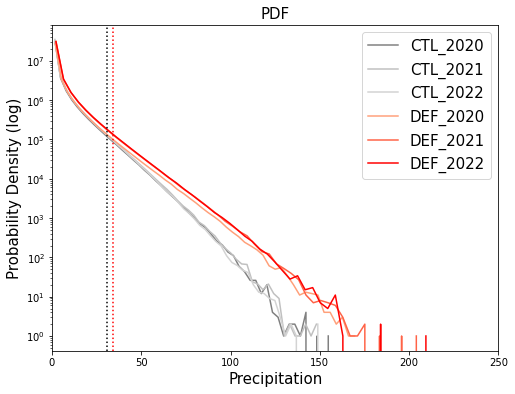

In [44]:
# Non-ormalize the PDF
pdf_ctl_2020, bins_ctl_2020 = np.histogram(pr_ctl_mm_hour_mask_above1_2020_f, bins=50, density=False)  # Adjust the number of bins as needed (hist, bins)
pdf_def_2020, bins_def_2020 = np.histogram(pr_def_mm_hour_mask_above1_2020_f, bins=50, density=False)  # Adjust the number of bins as needed
pdf_ctl_2021, bins_ctl_2021 = np.histogram(pr_ctl_mm_hour_mask_above1_2021_f, bins=50, density=False)  # Adjust the number of bins as needed
pdf_def_2021, bins_def_2021 = np.histogram(pr_def_mm_hour_mask_above1_2021_f, bins=50, density=False)  # Adjust the number of bins as needed
pdf_ctl_2022, bins_ctl_2022 = np.histogram(pr_ctl_mm_hour_mask_above1_2022_f, bins=50, density=False)  # Adjust the number of bins as needed
pdf_def_2022, bins_def_2022 = np.histogram(pr_def_mm_hour_mask_above1_2022_f, bins=50, density=False)  # Adjust the number of bins as needed

# Calculate the bin centers
bin_centers_ctl_2020 = (bins_ctl_2020[:-1] + bins_ctl_2020[1:]) * 0.5
bin_centers_def_2020 = (bins_def_2020[:-1] + bins_def_2020[1:]) * 0.5
bin_centers_ctl_2021 = (bins_ctl_2021[:-1] + bins_ctl_2021[1:]) * 0.5
bin_centers_def_2021 = (bins_def_2021[:-1] + bins_def_2021[1:]) * 0.5
bin_centers_ctl_2022 = (bins_ctl_2022[:-1] + bins_ctl_2022[1:]) * 0.5
bin_centers_def_2022 = (bins_def_2022[:-1] + bins_def_2022[1:]) * 0.5
    
# Plot the PDF
clr = ['gray', 'silver', 'lightgray', 'lightsalmon', 'tomato', 'red'] 

fig = plt.figure(figsize=(8, 6))
plt.plot(bin_centers_ctl_2020, pdf_ctl_2020, label='CTL_2020', color=clr[0])
plt.plot(bin_centers_ctl_2021, pdf_ctl_2021, label='CTL_2021', color=clr[1])
plt.plot(bin_centers_ctl_2022, pdf_ctl_2022, label='CTL_2022', color=clr[2])
plt.plot(bin_centers_def_2020, pdf_def_2020, label='DEF_2020', color=clr[3])
plt.plot(bin_centers_def_2021, pdf_def_2021, label='DEF_2021', color=clr[4])
plt.plot(bin_centers_def_2022, pdf_def_2022, label='DEF_2022', color=clr[5])

# Set labels and title
plt.xlabel('Precipitation', fontsize='15')
plt.ylabel('Probability Density (log)', fontsize='15')
plt.title('PDF', fontsize='15')
plt.yscale('log')
#plt.xscale('log')

plt.xlim(0, 250)

# plot p99
plt.axvline(pr_ctl_mm_hour_mask_above1_f_q99, color='black', ls=':')
plt.axvline(pr_def_mm_hour_mask_above1_f_q99, color='red', ls=':')

# add legend
plt.legend(fontsize=15)

# Display the plot
plt.show()

In [51]:
# print quantile 99
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask']

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] + '_f_q99'
        xarray_data = globals()[dset_name]
        print(xarray_data)

9.951086769103995
9.994010725021298
nan
nan
nan
nan
4.731624279022071
4.86936042308804
5.874236512184133
nan
nan
9.343930759429924


In [52]:
# print quantile 99
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_def_mm_hour_mask']

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name = name + '_' + mon_names[i-1] + '_f_q99'
        xarray_data = globals()[dset_name]
        print(xarray_data)

9.49865750312803
9.578183927535946
nan
nan
nan
nan
4.319746036529523
3.456812038421617
4.950095434188839
nan
nan
9.493036203384364


# Contour plot above q99

**Quantile for each month**

_throw all data to calculate q99 and count the numbers of hours when it is over the q99_

## Summation for the days which above the threshold

_calculate summed number of days_

In [47]:
# for each month, with different thresholds
mon_names = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

for name in xarray_names:
    for i in np.arange(1,13):
        dset_name_1 = name + '_' + mon_names[i-1] # 3d data 
        xarray_data = globals()[dset_name_1]
        dset_name_2 = name + '_' + mon_names[i-1] + '_f'
        
        # ref from the single value
        #xarray_data_q99 = globals()['pr_ctl_mm_hour_mask_f_q99']
        
        # select only ctl for the reference (ref from each month)
        if 'ctl' in name:
            q99_name = dset_name_2 + '_q99' # for each month
            xarray_data_q99 = globals()[q99_name]
        else:
            q99_name = dset_name_2.replace('def','ctl') + '_q99'
            xarray_data_q99 = globals()[q99_name]
        
        xarray_data_q99_counts = xr.where(xarray_data > xarray_data_q99, 1, np.nan) # above one value
        #print(np.shape(xarray_data_q99_counts))
        count_above_threshold = xarray_data_q99_counts.sum(dim='time')
    
        new_name = name + '_' + mon_names[i-1] + '_q99_counts'
        globals()[new_name] = count_above_threshold

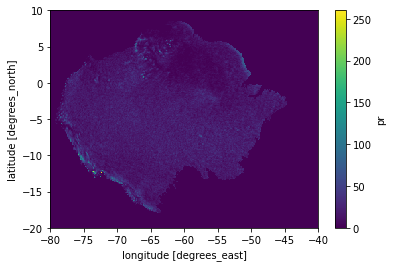

In [49]:
pr_ctl_mm_hour_mask_jan_q99_counts.plot()

In [16]:
# for each month, with one threshold
mon_names = ['jan','feb','jul','aug','sep','dec']
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

for name in xarray_names:
    for i in np.arange(1,7):
        dset_name = name + '_' + mon_names[i-1] # 3d data 
        xarray_data = globals()[dset_name]
        
        # ref from the single value
        xarray_data_q99 = globals()['pr_ctl_mm_hour_mask_f_q99']
        
        xarray_data_q99_counts = xr.where(xarray_data > xarray_data_q99, 1, np.nan) # above one value
        #print(np.shape(xarray_data_q99_counts))
        count_above_threshold = xarray_data_q99_counts.sum(dim='time')
    
        new_name = name + '_' + mon_names[i-1] + '_q99_counts'
        globals()[new_name] = count_above_threshold

In [17]:
# total precipitation, one q99 for all months
#mon_names = ['jan','feb','jul','aug','sep','dec']
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask'] # 3d data

for name in xarray_names:
    dset_name_1 = name # 3d data 
    xarray_data = globals()[dset_name_1]
    
    # ref from the single value
    xarray_data_q99 = globals()['pr_ctl_mm_hour_mask_f_q99']
    
    xarray_data_q99_counts = xr.where(xarray_data > xarray_data_q99, 1, np.nan) # above one value
    #print(np.shape(xarray_data_q99_counts))
    count_above_threshold = xarray_data_q99_counts.sum(dim='time')

    new_name = name + '_q99_counts'
    globals()[new_name] = count_above_threshold

_check the threshold_

In [30]:
a = xr.where(pr_ctl_mm_hour_mask > pr_ctl_mm_hour_mask_f_q99, 1, np.nan)
b= a.sum(dim='time')
b

<xarray.DataArray 'pr' (lat: 300, lon: 400)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon        (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05
  * lat        (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
    latitude   (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
    longitude  (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05

In [38]:
b_flat = b.values.flatten()
b_flat_2 = b_flat[~np.isnan(b_flat)]

143.0 249.0


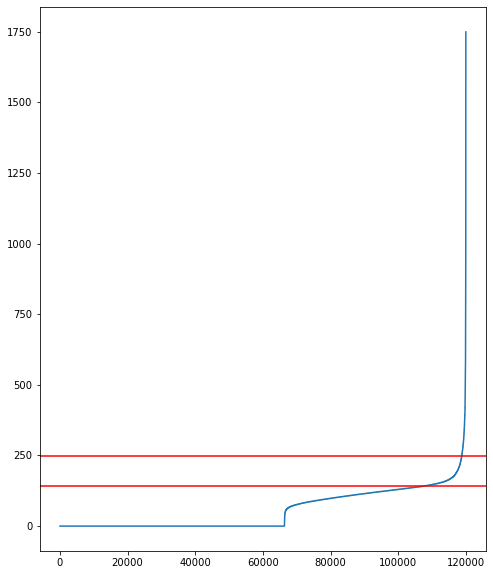

In [45]:
fig = plt.figure(figsize=[8,10],facecolor='w')
sorthed_precipitation = np.sort(b_flat_2)
plt.plot(sorthed_precipitation)
plt.axhline(y=np.quantile(b_flat_2, 0.9), color='r', linestyle='-')
plt.axhline(y=np.quantile(b_flat_2, 0.99), color='r', linestyle='-')
print(np.quantile(b_flat_2, 0.9), np.quantile(b_flat_2, 0.99))

### Accumulated numbers of times plottings

In [62]:
def contourf_extreme(data, cmap, varmin, varmax, space, extend, title):
    fig = plt.figure(figsize=[8,10],facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    ax.set_extent([-85,-35,-20,10])
    ax.coastlines('50m',linewidth=0.8)
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                    xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False
    
    # define lat and lon
    lats = pr_ctl_mm_hour_mask.lat
    lons = pr_ctl_mm_hour_mask.lon

    # Apply the same threshold to both datasets (pr_ctl_mm_hour_mask_q99_counts)
    m = ax.pcolormesh(lons,lats,data,cmap=cmap,vmin=varmin,vmax=varmax,transform=ccrs.PlateCarree())

    #ax.clabel(a, inline=True, fontsize=20)
    #ax.clabel(b, inline=True, fontsize=20)

    kw = {'levels':[-1], 'colors':['lightgrey'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    **kw
                    )
    bounds = np.linspace(varmin, varmax, space)
    cb = plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.ax.tick_params(labelsize=25)
    cb.ax.set_xticklabels(bounds,rotation=270)

    plt.title(title, fontsize='20')
    plt.show()

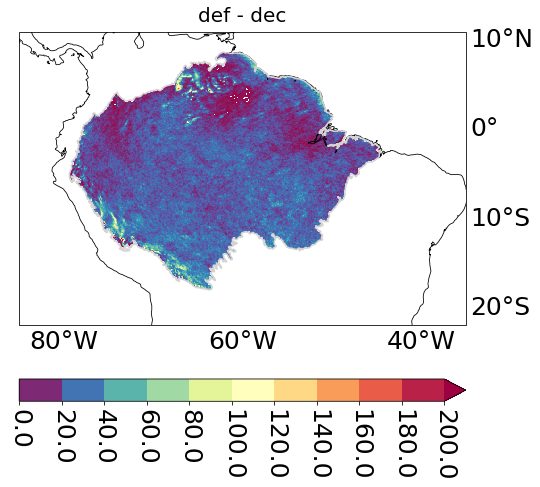

In [86]:
contourf_extreme(pr_def_mm_hour_mask_dec_q99_counts.where(pr_def_mm_hour_mask_dec_q99_counts != 0), 
                 spectral_cyclic, 0,200,11, 'max', 'def - dec')

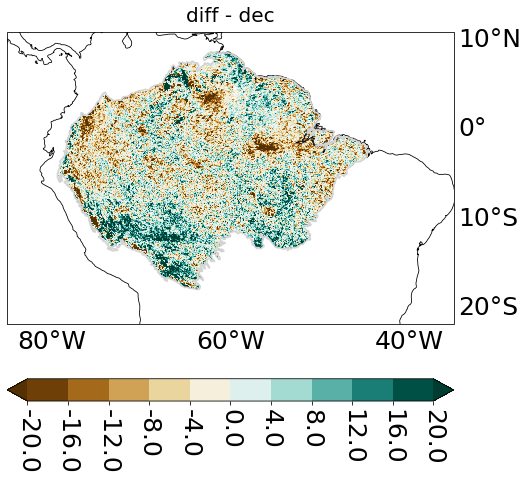

In [103]:
contourf_extreme(pr_def_mm_hour_mask_dec_q99_counts.where(pr_def_mm_hour_mask_dec_q99_counts != 0)-pr_ctl_mm_hour_mask_dec_q99_counts.where(pr_ctl_mm_hour_mask_dec_q99_counts != 0), 
                 'BrBG', -20,20,11, 'both', 'diff - dec')

In [76]:
sum = pr_ctl_mm_hour_mask_jan_q99_counts + pr_ctl_mm_hour_mask_feb_q99_counts + pr_ctl_mm_hour_mask_jul_q99_counts + pr_ctl_mm_hour_mask_aug_q99_counts + pr_ctl_mm_hour_mask_sep_q99_counts + pr_ctl_mm_hour_mask_dec_q99_counts

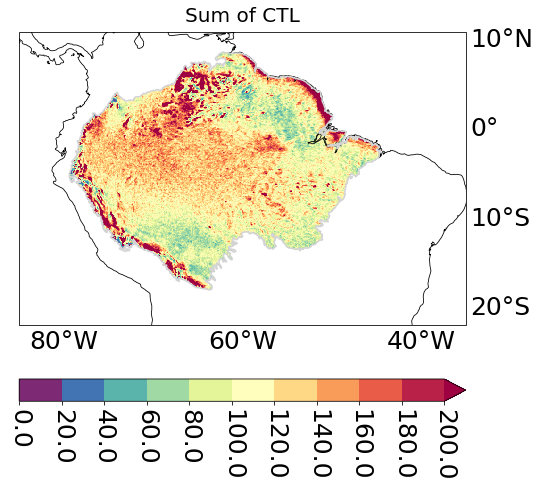

In [102]:
contourf_extreme(sum.where(sum != 0), spectral_cyclic, 0,200,11, 'max', 'Sum of CTL')

In [ ]:
# above1, or non-above1
dset_name_ctl = ['pr_ctl_mm_hour_mask_jan_q99_counts','pr_ctl_mm_hour_mask_feb_q99_counts','pr_ctl_mm_hour_mask_jul_q99_counts','pr_ctl_mm_hour_mask_aug_q99_counts',
             'pr_ctl_mm_hour_mask_sep_q99_counts','pr_ctl_mm_hour_mask_dec_q99_counts']
title = ['jan','feb','jul','aug','sep','dec']

for i in np.arange(0,6):
    contourf_extreme(globals()[dset_name_ctl[i]].where(globals()[dset_name_ctl[i]]!= 0), spectral_cyclic, 0,200,11, 'max', title[i])

In [120]:
def line_and_color(data, cmap, varmin, varmax, space, extend, quantile, title):
    fig = plt.figure(figsize=[8,10],facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    ax.set_extent([-85,-35,-20,10])
    ax.coastlines('50m',linewidth=0.8)
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                    xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False
    
    # define lat and lon
    lats = pr_ctl_mm_hour_mask.lat
    lons = pr_ctl_mm_hour_mask.lon

    # Number of times the threshold is exceeded
    m = ax.pcolormesh(lons,lats,data,cmap=cmap,vmin=varmin,vmax=varmax,transform=ccrs.PlateCarree())

    # contour line for the dataset above another threshold
    #a = data.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=np.linspace(data.quantile(quantile_low), ctl_masked_precipitation.quantile(quantile_upper), level_n), 
    #                                          colors='k', linewidths=1)
    a = data.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[data.quantile(quantile)+0.01],
                                              colors='k', linewidths=1.5)
        
    #ax.clabel(a, inline=True, fontsize=20)
    #ax.clabel(b, inline=True, fontsize=20)

    kw = {'levels':[-1], 'colors':['lightgrey'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    **kw
                    )
    bounds = np.linspace(varmin, varmax, space)
    cb = plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10, extend=extend,ticks=bounds, boundaries=bounds)
    cb.ax.tick_params(labelsize=25)
    cb.ax.set_xticklabels(bounds,rotation=270)

    plt.title(title, fontsize='20')
    plt.show()

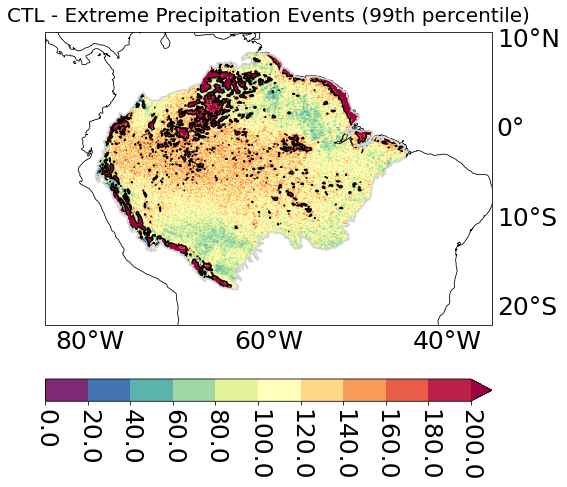

In [107]:
line_and_color(pr_ctl_mm_hour_mask_q99_counts.where(pr_ctl_mm_hour_mask_q99_counts != 0), spectral_cyclic, 0,200,11, 'max', 0.9,'CTL - Extreme Precipitation Events (99th percentile)')

In [111]:
pr_ctl_mm_hour_mask_q99_counts.where(pr_ctl_mm_hour_mask_q99_counts != 0).quantile(0.9)

<xarray.DataArray 'pr' ()>
array(162.)
Coordinates:
    quantile  float64 0.9

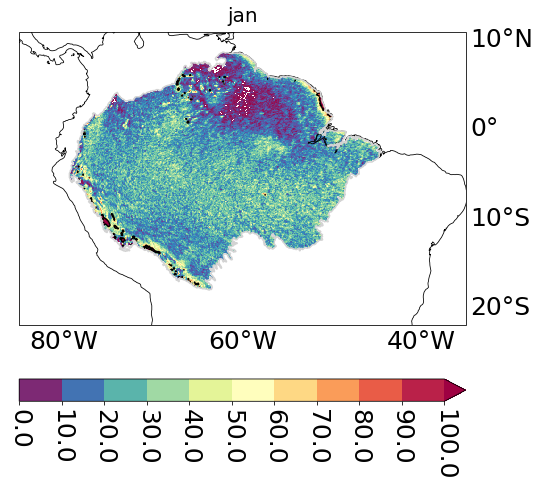

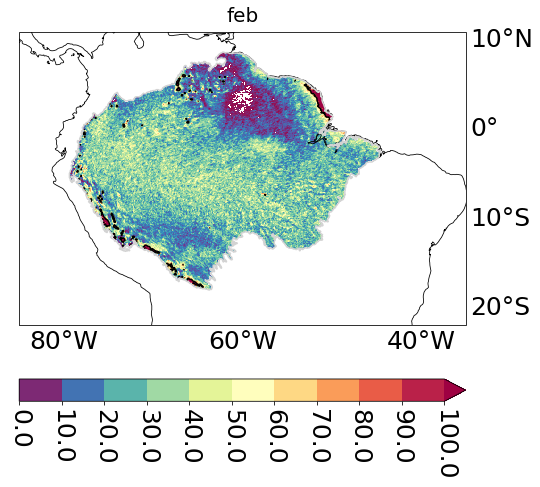

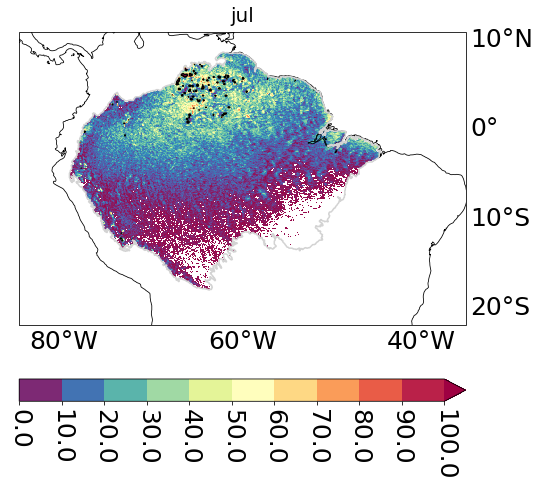

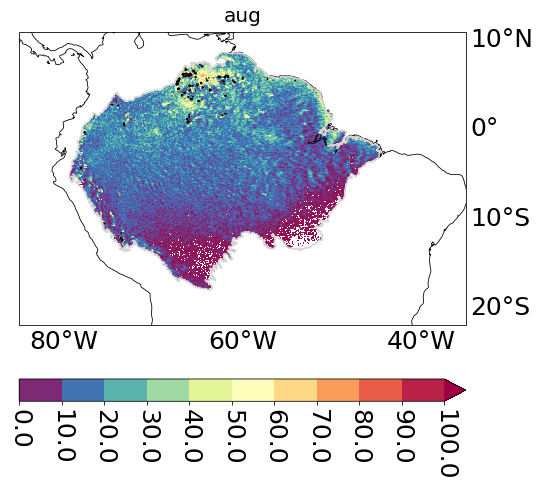

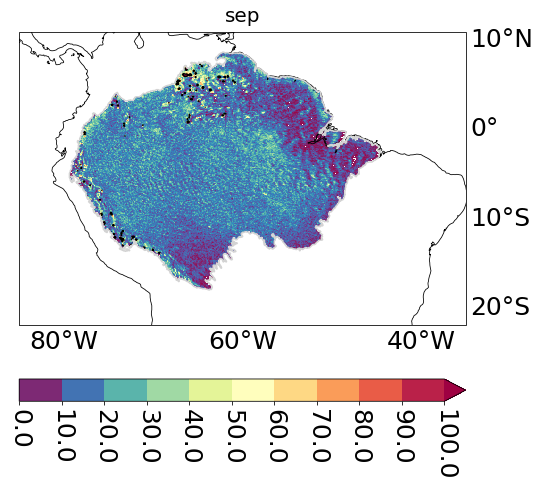

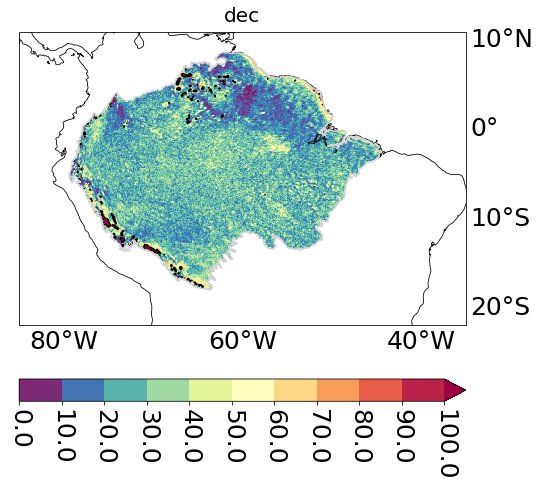

In [119]:
# above1, or non-above1
dset_name_ctl = ['pr_ctl_mm_hour_mask_jan_q99_counts','pr_ctl_mm_hour_mask_feb_q99_counts','pr_ctl_mm_hour_mask_jul_q99_counts','pr_ctl_mm_hour_mask_aug_q99_counts',
             'pr_ctl_mm_hour_mask_sep_q99_counts','pr_ctl_mm_hour_mask_dec_q99_counts']
title = ['jan','feb','jul','aug','sep','dec']

for i in np.arange(0,6):
    line_and_color(globals()[dset_name_ctl[i]].where(globals()[dset_name_ctl[i]]!= 0), spectral_cyclic, 0,100,11, 'max', 0.1, title[i])

In [114]:
print(pr_ctl_mm_hour_mask_jan_q99_counts.where(pr_ctl_mm_hour_mask_jan_q99_counts != 0).quantile(0.9),
      pr_ctl_mm_hour_mask_feb_q99_counts.where(pr_ctl_mm_hour_mask_feb_q99_counts != 0).quantile(0.9),
      pr_ctl_mm_hour_mask_jul_q99_counts.where(pr_ctl_mm_hour_mask_jul_q99_counts != 0).quantile(0.9),
      pr_ctl_mm_hour_mask_aug_q99_counts.where(pr_ctl_mm_hour_mask_aug_q99_counts != 0).quantile(0.9),
      pr_ctl_mm_hour_mask_sep_q99_counts.where(pr_ctl_mm_hour_mask_sep_q99_counts != 0).quantile(0.9),
      pr_ctl_mm_hour_mask_dec_q99_counts.where(pr_ctl_mm_hour_mask_dec_q99_counts != 0).quantile(0.9))

<xarray.DataArray 'pr' ()>
array(35.)
Coordinates:
    quantile  float64 0.9 <xarray.DataArray 'pr' ()>
array(41.)
Coordinates:
    quantile  float64 0.9 <xarray.DataArray 'pr' ()>
array(32.)
Coordinates:
    quantile  float64 0.9 <xarray.DataArray 'pr' ()>
array(27.)
Coordinates:
    quantile  float64 0.9 <xarray.DataArray 'pr' ()>
array(26.)
Coordinates:
    quantile  float64 0.9 <xarray.DataArray 'pr' ()>
array(39.)
Coordinates:
    quantile  float64 0.9


### Contour line plotting

In [125]:
def contour_extreme(data_ctl, data_def, quantile, title):
    fig = plt.figure(figsize=[8,10],facecolor='w')
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    ax.set_extent([-85,-35,-20,10])
    ax.coastlines('50m',linewidth=0.8)
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray',
                    xlocs=range(-180,180,20), ylocs=range(-90,90,10), crs=ccrs.PlateCarree())
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 25}, {'fontsize': 25}
    # manipulate `gridliner` object
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlines = False
    gl.ylines = False
    
    # Mask out values below the threshold
    ctl_masked_precipitation = data_ctl.where(data_ctl > 1)
    def_masked_precipitation = data_def.where(data_def > 1)

    # Apply the same threshold to both datasets (ctl_masked_precipitation)
    a = ctl_masked_precipitation.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[ctl_masked_precipitation.quantile(quantile)+0.01], 
                                              colors='k', linewidths=1)
    b = def_masked_precipitation.plot.contour(ax=ax, transform=ccrs.PlateCarree(), levels=[def_masked_precipitation.quantile(quantile)+0.01],
                                              colors='r', linewidths=1)

    #ax.clabel(a, inline=True, fontsize=20)
    #ax.clabel(b, inline=True, fontsize=20)

    kw = {'levels':[-1], 'colors':['lightgrey'], 'linestyles':['solid']}
    plot_bd = AMZ_BD.plot.contour( 
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    **kw
                    )

    plt.title(title, fontsize='20')
    plt.show()

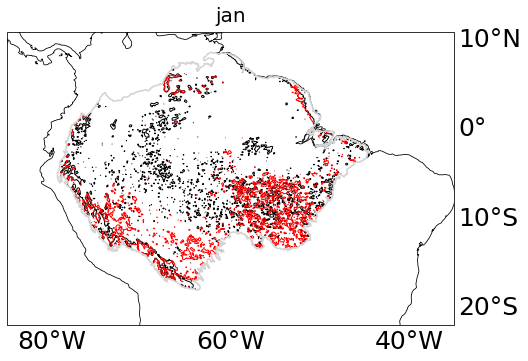

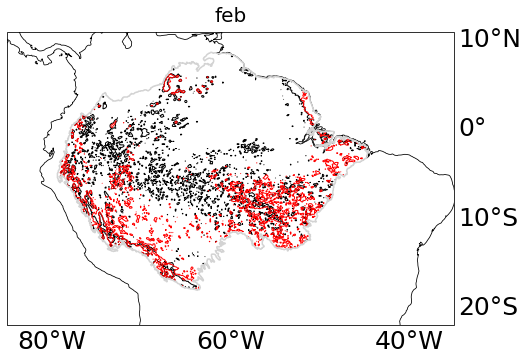

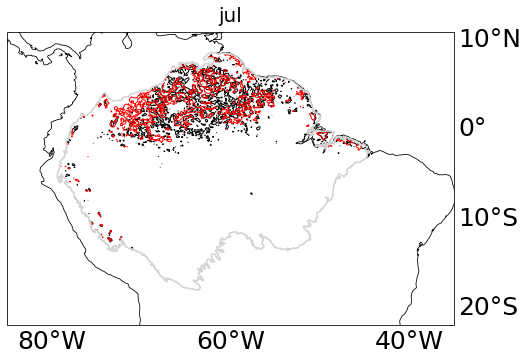

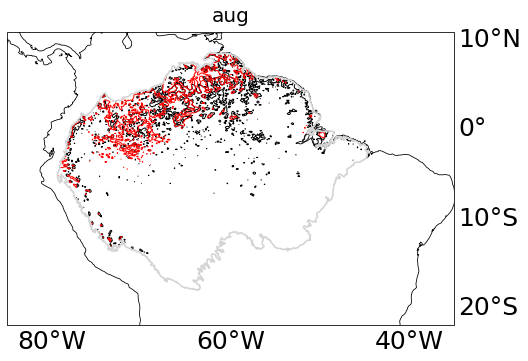

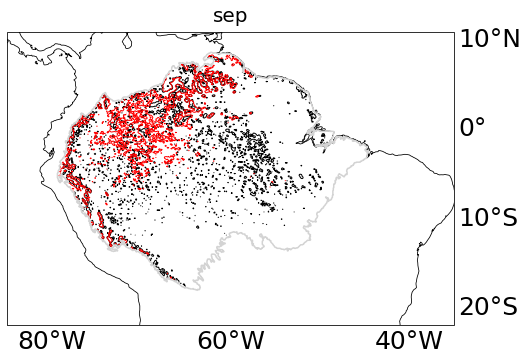

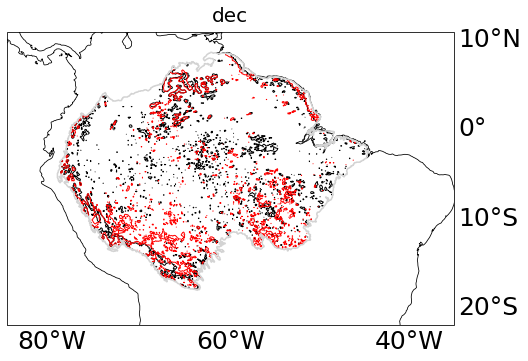

In [126]:
# above1, or non-above1
dset_name_ctl = ['pr_ctl_mm_hour_mask_jan_q99_counts','pr_ctl_mm_hour_mask_feb_q99_counts','pr_ctl_mm_hour_mask_jul_q99_counts','pr_ctl_mm_hour_mask_aug_q99_counts',
             'pr_ctl_mm_hour_mask_sep_q99_counts','pr_ctl_mm_hour_mask_dec_q99_counts']
dset_name_def = ['pr_def_mm_hour_mask_jan_q99_counts','pr_def_mm_hour_mask_feb_q99_counts','pr_def_mm_hour_mask_jul_q99_counts','pr_def_mm_hour_mask_aug_q99_counts',
             'pr_def_mm_hour_mask_sep_q99_counts','pr_def_mm_hour_mask_dec_q99_counts']
title = ['jan','feb','jul','aug','sep','dec']

for i in np.arange(0,6):
    contour_extreme(globals()[dset_name_ctl[i]], globals()[dset_name_def[i]], 0.9, title[i])

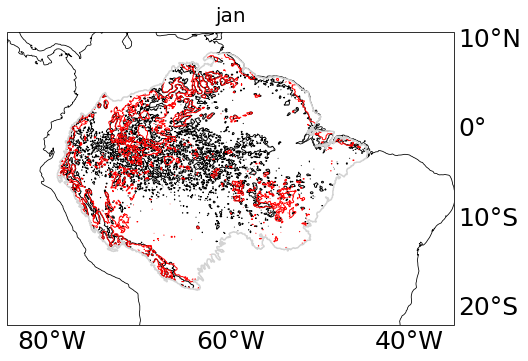

In [55]:
# above1, or non-above1
dset_name_ctl = ['pr_ctl_mm_hour_mask_q99_counts']
dset_name_def = ['pr_def_mm_hour_mask_q99_counts']

for i in np.arange(0,1):
    contour_extreme(globals()[dset_name_ctl[i]], globals()[dset_name_def[i]], 0.9, 1, 1, title[i])

# Diurnal cycle

_Add lst_

In [11]:
# divide longitude into 15 degree intervals
pr_ctl_mm_hour_mask['time_zone'] = np.round(pd.to_numeric(pr_ctl_mm_hour_mask['lon'],errors = 'coerce')/15)
pr_ctl_mm_hour_mask['local_time'] = pr_ctl_mm_hour_mask['time']-(-1*pr_ctl_mm_hour_mask['time_zone']).astype('timedelta64[h]')

In [12]:
pr_def_mm_hour_mask['time_zone'] = np.round(pd.to_numeric(pr_def_mm_hour_mask['lon'],errors = 'coerce')/15)
pr_def_mm_hour_mask['local_time'] = pr_def_mm_hour_mask['time']-(-1*pr_def_mm_hour_mask['time_zone']).astype('timedelta64[h]')

_The whole year_

In [13]:
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

for name in xarray_names:
    xarray_data = globals()[name]
    
    xarray_utc = xarray_data.groupby(xarray_data.time.dt.hour).mean()
    xarray_lst = xarray_data.groupby(xarray_data.local_time.dt.hour).mean()
    
    xarray_utc_avg = xarray_utc.mean(dim=('lat','lon'))
    xarray_lst_avg = xarray_lst.mean(dim=('lat'))
    
    new_name_utc = name + '_utc_avg'
    new_name_lst = name + '_lst_avg'
    
    globals()[new_name_utc] = xarray_utc_avg
    globals()[new_name_lst] = xarray_lst_avg

Text(0.5, 1.0, 'Diurnal cycle')

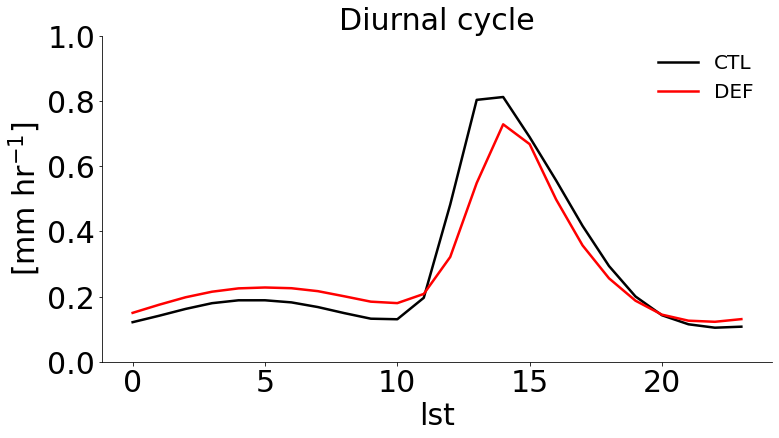

In [16]:
import seaborn as sns
pf, ax = plt.subplots(1, 1, figsize=(12,6)); hh = np.arange(0,24,1)
ax.plot(pr_ctl_mm_hour_mask_lst_avg,color='black',label='CTL',linewidth=2.5)
ax.plot(pr_def_mm_hour_mask_lst_avg,color='red', label='DEF',linewidth=2.5)

ax.set_ylabel('[mm hr${^{-1}}$]',fontsize=30); ax.set_xlabel('lst',fontsize=30)
sns.despine()
ax.legend(fontsize=20,frameon=False)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.ylim(0, 1)
plt.title('Diurnal cycle',fontsize=30)

_Separate months_

In [35]:
# hourly, all years into each month
mon_names = ['jan','feb','mar','apr','may','may','jul','aug','sep','oct','nov','dec']

xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']

for name in xarray_names:
    xarray_data = globals()[name]
    for i in np.arange(1,13):
        xarray_data_mon = xarray_data.where(xarray_data.time.dt.month.isin([i]), drop=True)
        new_name = name + '_' + mon_names[i-1] 
        globals()[new_name] = xarray_data_mon

In [36]:
xarray_names = ['pr_ctl_mm_hour_mask','pr_def_mm_hour_mask']
mon_names = ['jan','feb','jul','aug','sep','dec']

for name in xarray_names:
    for i in np.arange(1,7):
        new_name = name + '_' + mon_names[i-1] 
        xarray_data = globals()[new_name]
        
        xarray_utc = xarray_data.groupby(xarray_data.time.dt.hour).mean()
        xarray_lst = xarray_data.groupby(xarray_data.local_time.dt.hour).mean()
        
        xarray_utc_avg = xarray_utc.mean(dim=('lat','lon'))
        xarray_lst_avg = xarray_lst.mean(dim=('lat'))
        
        new_name_utc = new_name + '_utc_avg'
        new_name_lst = new_name + '_lst_avg'
        
        globals()[new_name_utc] = xarray_utc_avg
        globals()[new_name_lst] = xarray_lst_avg

_Separate into individual months_

Text(0.5, 1.0, 'dec')

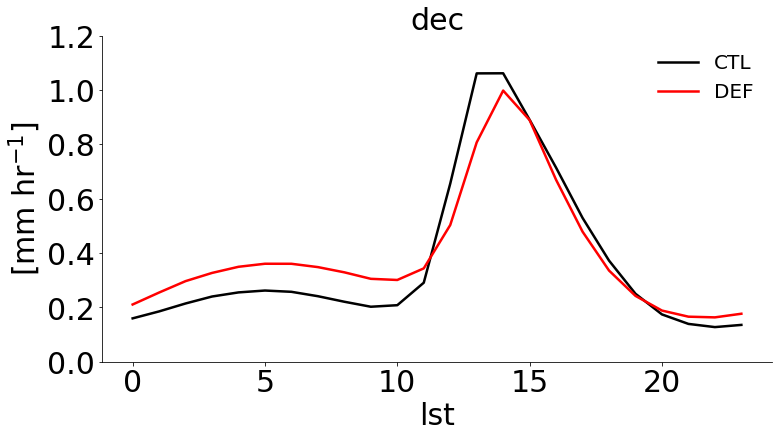

In [46]:
import seaborn as sns
pf, ax = plt.subplots(1, 1, figsize=(12,6)); hh = np.arange(0,24,1)
ax.plot(pr_ctl_mm_hour_mask_dec_lst_avg,color='black',label='CTL',linewidth=2.5)
ax.plot(pr_def_mm_hour_mask_dec_lst_avg,color='red', label='DEF',linewidth=2.5)

ax.set_ylabel('[mm hr${^{-1}}$]',fontsize=30); ax.set_xlabel('lst',fontsize=30)
sns.despine()
ax.legend(fontsize=20,frameon=False)
plt.xticks(fontsize=30,rotation=0)
plt.yticks(fontsize=30)
plt.ylim(0, 1.2)
plt.title('dec',fontsize=30)

# Maximum PR diurnal cycle

In [18]:
# nan values exist so can't use
def fith(x, nh=2):
    '''
    smooth output using Fast Fourier Transform. 
    x = data series
    nh = number of harmonics
    Retrieve only the first "nh" harmonics plus half of "nh+1" frequency 
    Return the inverse transform, i.e. reconstructed series 
    '''
    fft2=np.fft.rfft(x); 
    fft2[nh+1]=0.5*fft2[nh+1] 
    fft2[nh+2:]=0 
    data_f2=np.fft.irfft(fft2)
    return(data_f2)


In [19]:
# CTL
dsp = xr.Dataset(
    { "prec": (["hour", "lat", "lon"],pr_ctl_mm_hour_mask.groupby('time.hour').mean('time').values)},
    coords={ "hour":pr_ctl_mm_hour_mask.groupby('time.hour').mean('time').hour,
            "lat": (["lat"],pr_ctl_mm_hour_mask.lat.values),
            "lon": (["lon"],pr_ctl_mm_hour_mask.lon.values)})
dshpc = xr.apply_ufunc(fith,dsp.sel(lon=slice(-80,-29),lat=slice(
    -25,10)).prec,input_core_dims=[["hour"]], 
    output_core_dims=[['hour']], dask = 'allowed', vectorize = True, kwargs={"nh": 2})

In [20]:
# DEF
ddf = xr.Dataset(
    { "prec": (["hour", "lat", "lon"],pr_def_mm_hour_mask.groupby('time.hour').mean('time').values)},
    coords={ "hour":pr_def_mm_hour_mask.groupby('time.hour').mean('time').hour,
            "lat": (["lat"],pr_def_mm_hour_mask.lat.values),
            "lon": (["lon"],pr_def_mm_hour_mask.lon.values)})
defpc = xr.apply_ufunc(fith,ddf.sel(lon=slice(-80,-29),lat=slice(
    -25,10)).prec,input_core_dims=[["hour"]], 
    output_core_dims=[['hour']], dask = 'allowed', vectorize = True, kwargs={"nh": 2})

In [21]:
to_localtime_ctl = (pr_ctl_mm_hour_mask.lon /15) ; to_localtime_def = (pr_def_mm_hour_mask.lon /15) 

In [52]:
spectral_cyclic = LinearSegmentedColormap.from_list('mycmap',
                                                ['#9e0142', '#5e4fa2','#3288bd', '#66c2a5','#abdda4',
                                                '#e6f598','#ffffbf','#fee08b','#fdae61','#f46d43','#d53e4f','#9e0142',])

In [23]:
# CTL
rainmaxec = dshpc.max('hour'); 
timmaxec = dshpc.hour.where(dshpc == rainmaxec)
timer_ec = timmaxec.mean('hour')+np.round(to_localtime_ctl)

plh_ec = (timer_ec.where(
    timer_ec>=0,timer_ec+24))#.where( 
    #rainmaxec>0.1) # if you want to filter out, you can activate this command

rainmaxcm = dshpc.max('hour'); 
timmaxc = dshpc.hour.where(dshpc == rainmaxcm)
timer_cm = timmaxc.mean('hour')+np.round(to_localtime_ctl); 

plh_cm = (timer_cm.where(
    timer_cm>=0,timer_cm+24))#.where(
    #rainmaxcm>0.1)

In [24]:
# DEF
rainmaxec = defpc.max('hour'); 
timmaxec = defpc.hour.where(defpc == rainmaxec)
timer_ec = timmaxec.mean('hour')+np.round(to_localtime_def)

plh_ec = (timer_ec.where(
    timer_ec>=0,timer_ec+24))#.where(
    #rainmaxec>0.1)

rainmaxcm = defpc.max('hour'); 
timmaxc = defpc.hour.where(defpc == rainmaxcm)
timer_cm = timmaxc.mean('hour')+np.round(to_localtime_def); 

plh_df = (timer_cm.where(
    timer_cm>=0,timer_cm+24))#.where(
    #rainmaxcm>0.1)

In [25]:
def map_style(dax, title1='',
                     yl=True, xb = True, yloc = np.arange(-30,21,10), xloc = [-90,-75,-20,15,70],
                     ylimi=-10, ylimf=21, xlimi=-82, xlimf=20,cc='k',sz=11,
             hor='horizontal',pd=0.03):  
   
    dax.set_ylim(ylimi,ylimf); dax.set_xlim(xlimi,xlimf)
    dax.coastlines(resolution='50m',color=cc)
    dax.set_title(title1)
    gl = dax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False; gl.right_labels = False;
    gl.bottom_labels = xb;  gl.left_labels = yl;
    gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(yloc);  gl.xlocator = mticker.FixedLocator(xloc)
    gl.xlabel_style = {'size': sz, 'color': 'black'}; gl.ylabel_style = {'size': sz, 'color': 'black'}

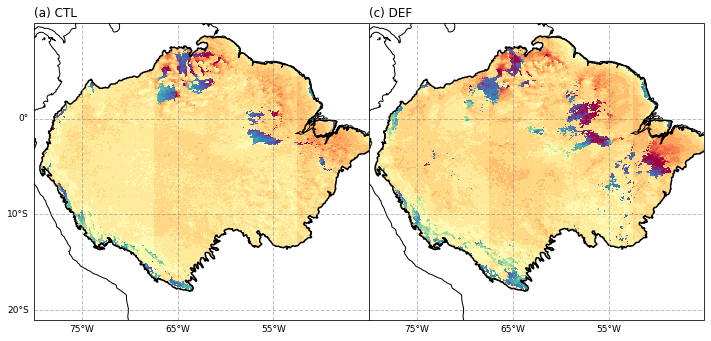

In [86]:
import matplotlib.ticker as mticker
fig = plt.figure(figsize=(24,8)); xf =-45; xi =-80; xl =[-90,-75,-65,-55,-45,-35]; yf=10; yi=-21; 
yl = [-25,-20,-15,-10,-5,0,5,10,15];

ax1 = plt.subplot(151, projection=ccrs.PlateCarree())
plh_cm.plot(ax=ax1,levels=np.arange(0,25,1),cmap=spectral_cyclic,
            extend='neither',rasterized=True,add_colorbar=False)
#ax1.plot(amaz2[:,0],amaz2[:,1],'k',linewidth=1); 
#ax1.plot(np.round(top_ec.topography_c)).sel(lon=slice(-81,-45),lat=slice(-20,10)).plot.contour(ax=ax1,levels=[1000],
#    colors='saddlebrown',linewidths=0.8)
#ax1.add_feature(rivers, linewidth=.25,edgecolor='k')
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,xloc=xl,sz=9)
ax1.set_title("(a) CTL ", loc="left")
kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

ax1 = plt.subplot(152, projection=ccrs.PlateCarree())
m = plh_df.plot(ax=ax1,levels=np.arange(0,25,1),cmap=spectral_cyclic,
            extend='neither',rasterized=True,add_colorbar=False)
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,yl=False,xloc=xl,sz=9)

#plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10)

ax1.set_title("(c) DEF ", loc="left")

kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

_Add time difference_

In [37]:
# set 14:00 as a reference time
#diff_cm = ((plh_df - plh_cm) % 24 + 12) % 24 - 12 # 14 -> 16: (((16-14)%24)+14)%24 -14 = 2; 5 -> 3: (((3-5)%24)+14)%24 -14 = -2; 23 -> 1: (((1-23)%24)+14)%24 -14 = 2
diff_cm_24 = (plh_df - plh_cm) % 24
diff_cm = (plh_df - plh_cm) 

diff_cm

<xarray.DataArray (lat: 300, lon: 400)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat        (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
  * lon        (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05
    longitude  (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05

In [148]:
diff_cm = diff_cm.where(diff_cm != 0)
diff_posi = diff_cm.where(diff_cm > 0)
diff_nega = diff_cm.where(diff_cm < 0)

In [27]:
spectral_cyclic = LinearSegmentedColormap.from_list('mycmap',
                                                ['#9e0142', '#5e4fa2','#3288bd', '#66c2a5','#abdda4',
                                                '#e6f598','#ffffbf','#fee08b','#fdae61','#f46d43','#d53e4f','#9e0142',])

' \n# positive only\nax1 = plt.subplot(154, projection=ccrs.PlateCarree())\nm = diff_posi.plot(ax=ax1,levels=np.arange(0,12,1),cmap=\'Reds\',\n            extend=\'neither\',rasterized=True,add_colorbar=False)\nmap_style(ax1,xlimi=xi,title1=\'\',xlimf=xf,ylimi=-21,ylimf=yf,yl=False,xloc=xl,sz=9)\n\nplt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10)\n\nax1.set_title("(d) DIFF (+) ", loc="left")\n\nkw = {\'levels\':[-1], \'colors\':[\'black\'], \'linestyles\':[\'solid\']}\nplot_bd = AMZ_BD.plot.contour( \n                      ax=ax1,\n                      transform=ccrs.PlateCarree(),\n                      **kw\n                     )\n    \n_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)\n\n\n# negative only\nax1 = plt.subplot(155, projection=ccrs.PlateCarree())\nm = diff_nega.plot(ax=ax1,levels=np.arange(-12,0,1),cmap=\'Blues_r\',\n            extend=\'neither\',rasterized=True,add_colorbar=False)\nmap_style(ax1,xlimi=xi,title

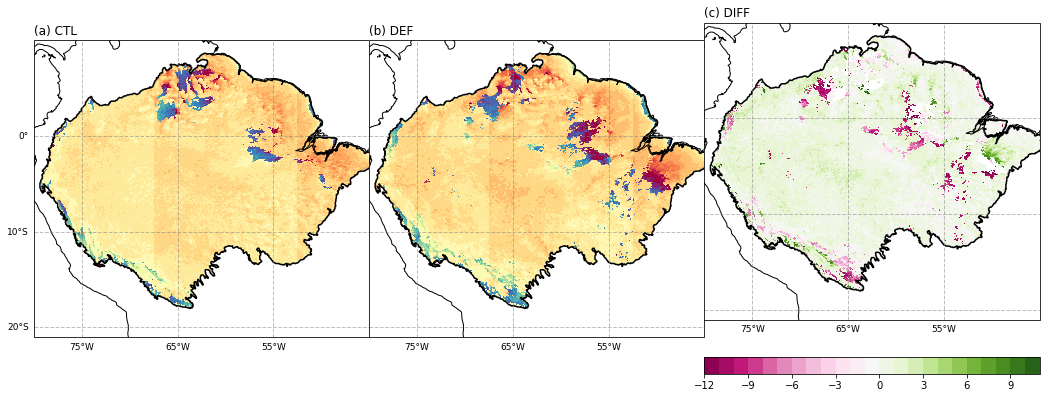

In [38]:
import matplotlib.ticker as mticker
fig = plt.figure(figsize=(24,8)); xf =-45; xi =-80; xl =[-90,-75,-65,-55,-45,-35]; yf=10; yi=-21; 
yl = [-25,-20,-15,-10,-5,0,5,10,15];

ax1 = plt.subplot(151, projection=ccrs.PlateCarree())
plh_cm.plot(ax=ax1,levels=np.arange(0,25,1),cmap=spectral_cyclic,
            extend='neither',rasterized=True,add_colorbar=False)
#ax1.plot(amaz2[:,0],amaz2[:,1],'k',linewidth=1); 
#ax1.plot(np.round(top_ec.topography_c)).sel(lon=slice(-81,-45),lat=slice(-20,10)).plot.contour(ax=ax1,levels=[1000],
#    colors='saddlebrown',linewidths=0.8)
#ax1.add_feature(rivers, linewidth=.25,edgecolor='k')
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,xloc=xl,sz=9)
ax1.set_title("(a) CTL ", loc="left")
kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

ax1 = plt.subplot(152, projection=ccrs.PlateCarree())
m_def = plh_df.plot(ax=ax1,levels=np.arange(0,25,1),cmap=spectral_cyclic,
            extend='neither',rasterized=True,add_colorbar=False)
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,yl=False,xloc=xl,sz=9)

#plt.colorbar(m_def, orientation="horizontal", fraction=0.05, pad=0.10)

ax1.set_title("(b) DEF ", loc="left")

kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

ax1 = plt.subplot(153, projection=ccrs.PlateCarree())
m = diff_cm.plot(ax=ax1,levels=np.arange(-12,12,1),cmap='PiYG',
            extend='neither',rasterized=True,add_colorbar=False)
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,yl=False,xloc=xl,sz=9)

plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10)

ax1.set_title("(c) DIFF ", loc="left")

kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)

""" 
# positive only
ax1 = plt.subplot(154, projection=ccrs.PlateCarree())
m = diff_posi.plot(ax=ax1,levels=np.arange(0,12,1),cmap='Reds',
            extend='neither',rasterized=True,add_colorbar=False)
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,yl=False,xloc=xl,sz=9)

plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10)

ax1.set_title("(d) DIFF (+) ", loc="left")

kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25)


# negative only
ax1 = plt.subplot(155, projection=ccrs.PlateCarree())
m = diff_nega.plot(ax=ax1,levels=np.arange(-12,0,1),cmap='Blues_r',
            extend='neither',rasterized=True,add_colorbar=False)
map_style(ax1,xlimi=xi,title1='',xlimf=xf,ylimi=-21,ylimf=yf,yl=False,xloc=xl,sz=9)

plt.colorbar(m, orientation="horizontal", fraction=0.05, pad=0.10)

ax1.set_title("(e) DIFF (-)", loc="left")

kw = {'levels':[-1], 'colors':['black'], 'linestyles':['solid']}
plot_bd = AMZ_BD.plot.contour( 
                      ax=ax1,
                      transform=ccrs.PlateCarree(),
                      **kw
                     )
    
_ = fig.subplots_adjust(left=0.01, right=0.98, hspace=0, wspace=0, top=0.9, bottom=0.25) """

# The frequency of each intensity for each time

In [10]:
pr_ctl_time = pr_ctl_mm_hour_mask.mean(dim=['lat', 'lon'])
pr_def_time = pr_def_mm_hour_mask.mean(dim=['lat', 'lon'])

In [10]:
pr_ctl_mm_hour_mask

<xarray.DataArray 'pr' (time: 25825, lat: 300, lon: 400)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-20 ... 2022-12-31
  * lon        (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05
  * lat        (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
    latitude   (lat) float64 -19.95 -19.85 -19.75 -19.65 ... 9.65 9.75 9.85 9.95
    longitude  (lon) float64 -79.95 -79.85 -79.75 ... -40.25 -40.15 -40.05

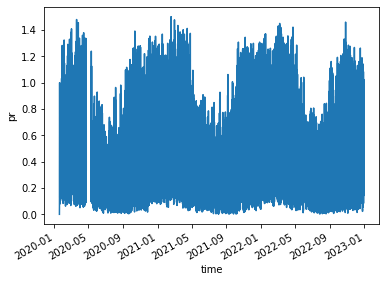

In [11]:
pr_ctl_time.plot() # mm/hr

In [11]:
# Define precipitation categories
bins = [0, 0.1, 0.5, 1.0, 1.5, np.inf] # 0, 0.1, 0.5, 1.0, 1.5, 2.0
labels = ['0.0-0.1', '0.1-0.5', '0.5-1.0', '1.0-1.5', '>1.5']

_1 dimensional data_

In [24]:
# Digitize the precipitation data
precip_ctl_categories = np.digitize(pr_ctl_time, bins) - 1
precip_def_categories = np.digitize(pr_def_time, bins) - 1

In [18]:
precip_categories

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
import pandas as pd

# Extract hour from the time coordinate
hours = pd.to_datetime(pr_ctl_time['time'].values).hour

_3 dimensional data_

In [ ]:
# Define a function to categorize precipitation data
def categorize_precip(data):
    return np.digitize(data, bins) - 1

# dataset with (time, lat, lon)
ds_time = pr_ctl_mm_hour_mask

# Apply the function to categorize precipitation data
categorized_precip = xr.apply_ufunc(
    categorize_precip,
    ds_time,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[int]
)

NameError: name 'precip_ctl_categories' is not defined

In [ ]:

# Add the categorized data to the dataset
ds_time['precip_categories'] = categorized_precip

_ctl_

In [25]:
# Create a DataFrame with the hours and precipitation categories
data = pd.DataFrame({'hour': hours, 'category': precip_ctl_categories})

# Count the occurrences of each category for each hour
hourly_counts = data.groupby('hour')['category'].value_counts().unstack(fill_value=0)

# Ensure all categories are included in the DataFrame
hourly_counts = hourly_counts.reindex(columns=range(len(labels)), fill_value=0)

# Convert to DataFrame with category labels
hourly_counts.columns = labels

_def_

In [35]:
# Create a DataFrame with the hours and precipitation categories
data = pd.DataFrame({'hour': hours, 'category': precip_def_categories})

# Count the occurrences of each category for each hour
hourly_counts = data.groupby('hour')['category'].value_counts().unstack(fill_value=0)

# Ensure all categories are included in the DataFrame
hourly_counts = hourly_counts.reindex(columns=range(len(labels)), fill_value=0)

# Convert to DataFrame with category labels
hourly_counts.columns = labels

In [36]:
# Convert counts to percentages
hourly_percentage_df = hourly_counts.div(hourly_counts.sum(axis=1), axis=0) * 100

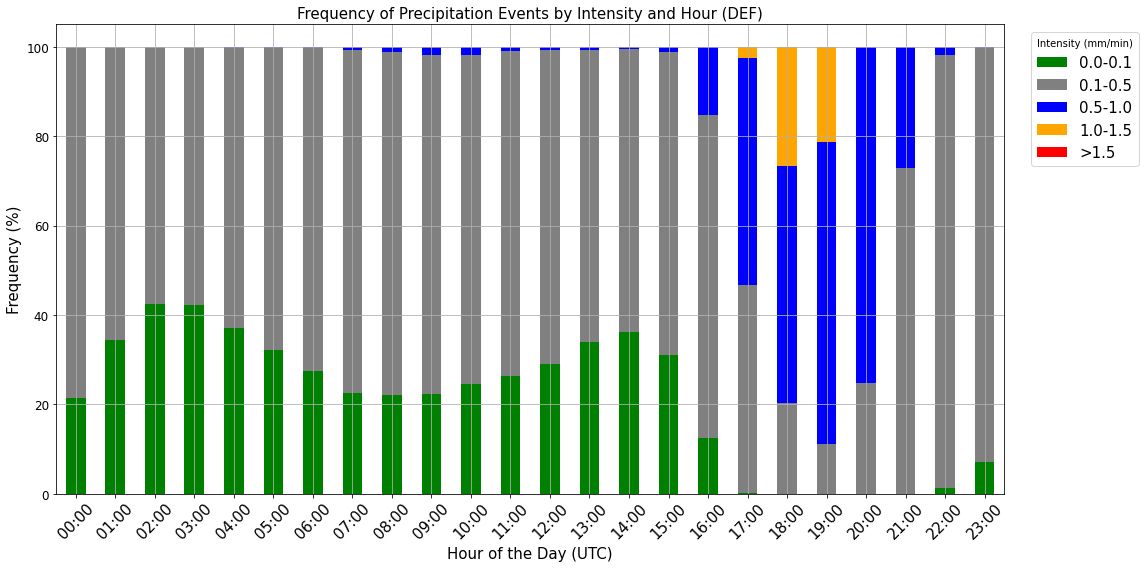

In [37]:
import matplotlib.pyplot as plt

# Create a bar plot
fig, ax = plt.subplots(figsize=(16, 8))

hourly_percentage_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'gray', 'blue', 'orange', 'red', 'darkred'])

# Customize the plot
ax.set_xlabel('Hour of the Day (UTC)', fontsize=15)
ax.set_ylabel('Frequency (%)', fontsize=15)
ax.set_title('Frequency of Precipitation Events by Intensity and Hour (DEF)', fontsize=15)
ax.legend(title='Intensity (mm/min)', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=15)
plt.xticks(range(24), [f'{hour:02d}:00' for hour in range(24)], rotation=45, fontsize=15)
plt.yticks(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


_saving the latitude and longitude_

In [ ]:
# Define a function to categorize precipitation data
def categorize_precip(data):
    return np.digitize(data, bins) - 1

# Apply the function to categorize precipitation data
categorized_precip = xr.apply_ufunc(
    categorize_precip,
    pr_ctl_mm_hour_mask.load(),
    vectorize=True,
    dask='parallelized',
    output_dtypes=[int]
)

KeyboardInterrupt: 

: 

: 

In [ ]:
categorized_precipe

In [ ]:
# Add the categorized data to the dataset
pr_ctl_mm_hour_mask['precip_categories'] = categorized_precip

# Extract hour from the time coordinate
pr_ctl_mm_hour_mask['hour'] = ('time', pd.to_datetime(pr_ctl_mm_hour_mask['time'].values).hour)

# Function to count occurrences in each category
def count_categories(data, num_categories):
    return np.bincount(data.values.flatten(), minlength=num_categories)

# Group by hour and count occurrences
hourly_counts = ds_time.groupby('hour')['precip_categories'].apply(count_categories, len(labels))

# Convert to DataFrame for easier manipulation
hourly_counts_df = pd.DataFrame(hourly_counts.values, columns=labels, index=range(24))

# Convert counts to percentages
total_counts_per_hour = hourly_counts_df.sum(axis=1)
hourly_percentage_df = hourly_counts_df.div(total_counts_per_hour, axis=0) * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))

hourly_percentage_df.plot(kind='bar', stacked=True, ax=ax, color=['white', 'gray', 'blue', 'orange', 'red'])

# Customize the plot
ax.set_xlabel('Hour of the Day (LST)')
ax.set_ylabel('Rain Area (%)')
ax.set_title('Frequency of Precipitation Events by Intensity and Hour')
ax.legend(title='Intensity (mm/min)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24), [f'{hour:02d}:00' for hour in range(24)], rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



In [74]:
# Function to count occurrences in each category
def count_categories(data, num_categories):
    return np.bincount(data.values.flatten(), minlength=num_categories)

# Group by hour and count occurrences
hourly_counts = pr_ctl_time.groupby('hour')['precip_categories'].apply(count_categories, len(labels))

# Convert to DataFrame for easier manipulation
hourly_counts_df = pd.DataFrame(hourly_counts.values, columns=labels, index=range(24))


KeyError: 'precip_categories'

(array([2760000.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  120000.]),
 array([1076. , 1076.1, 1076.2, 1076.3, 1076.4, 1076.5, 1076.6, 1076.7,
        1076.8, 1076.9, 1077. ]),
 <BarContainer object of 10 artists>)

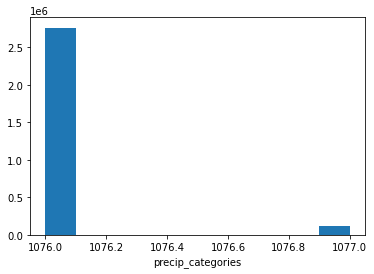

In [29]:
pr_ctl_hour_mask['precip_categories'].groupby('time.hour').count().plot()

# PDF for rainy and non-rainy days

### select the rainy days

In [ ]:
# hourly, all years and each month
 
xarray_names = ['pr_ctl_mask','pr_def_mask']

suffix = '_above1'

for name in xarray_names:
    dset_name = name 
    xarray_data = globals()[dset_name] * 3600 # mm/hour
    xarray_data_abov1 = xarray_data > 0.1 # only select the data above 0.1mm/hour -> 0 or 1
    
    new_name = dset_name + suffix
    globals()[new_name] = xarray_data_abov1

In [ ]:
# replace the 0 with nan
ctl_rainy = pr_ctl_mask_above1.where(pr_ctl_mask_above1 != 0)
def_rainy = pr_def_mask_above1.where(pr_def_mask_above1 != 0)

In [ ]:
# Masking non-rainy days
is_rainy_day_ctl = ctl_rainy.resample(time='1D').max(dim='time')
is_rainy_day_def = def_rainy.resample(time='1D').max(dim='time')

In [ ]:
# broadcast the daily mask to hourly resolution
hourly_ctl_mask_rainy = is_rainy_day_ctl.reindex(time=wind_ctl_mask['time'], method='ffill')
hourly_def_mask_rainy = is_rainy_day_def.reindex(time=wind_def_mask['time'], method='ffill')

In [ ]:
# save the wind only on rainy days
wind_rainy_ctl = wind_ctl_mask.where(hourly_ctl_mask_rainy == 1)
wind_rainy_def = wind_def_mask.where(hourly_def_mask_rainy == 1)

In [ ]:
# save the wind only on non-rainy days
wind_nonrainy_ctl = wind_ctl_mask.where(hourly_ctl_mask_rainy != 1)
wind_nonrainy_def = wind_def_mask.where(hourly_def_mask_rainy != 1)

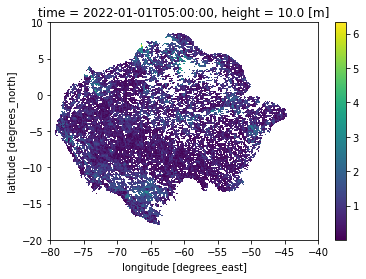

In [ ]:
wind_rainy_ctl.isel(time=10).plot()

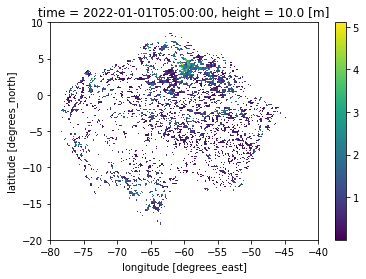

In [ ]:
wind_nonrainy_ctl.isel(time=10).plot()

_rainy days_

In [ ]:
xarray_names = ['wind_rainy_ctl','wind_rainy_def']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepd

In [ ]:
# year/month separation
new_suffix = '_q99'
xarray_names = ['wind_rainy_ctl','wind_rainy_def']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

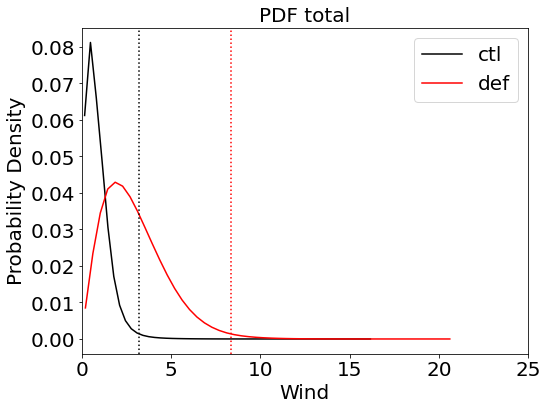

In [ ]:
plot_pdf(wind_rainy_ctl_f, wind_rainy_def_f, 50, 'ctl', 'def', 'black', 'red', 'PDF total', 'Wind', 25, wind_rainy_ctl_f_q99, wind_rainy_def_f_q99)

_non-rainy days_

In [ ]:
xarray_names = ['wind_nonrainy_ctl','wind_nonrainy_def']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [ ]:
# year/month separation
new_suffix = '_q99'
xarray_names = ['wind_nonrainy_ctl','wind_nonrainy_def']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

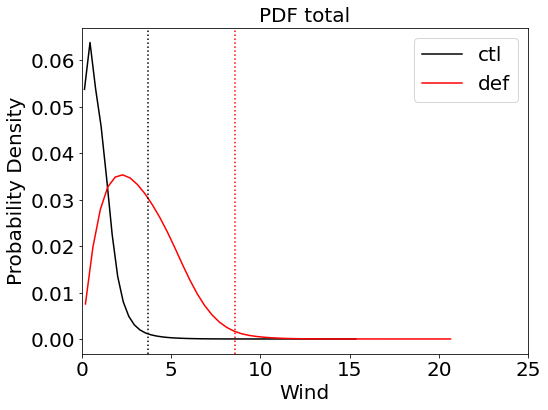

In [ ]:
plot_pdf(wind_nonrainy_ctl_f, wind_nonrainy_def_f, 50, 'ctl', 'def', 'black', 'red', 'PDF total', 'Wind', 25, wind_nonrainy_ctl_f_q99, wind_nonrainy_def_f_q99)

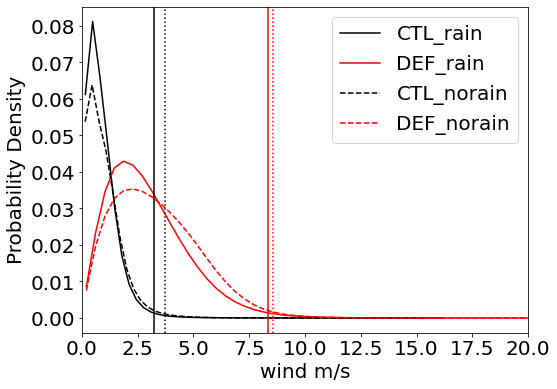

: 

In [ ]:
pdf_rainy_ctl, bins_rainy_ctl = np.histogram(wind_rainy_ctl_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_rainy_def, bins_rainy_def = np.histogram(wind_rainy_def_f, bins=50, density=True)
pdf_nonrainy_ctl, bins_nonrainy_ctl = np.histogram(wind_nonrainy_ctl_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_nonrainy_def, bins_nonrainy_def = np.histogram(wind_nonrainy_def_f, bins=50, density=True)

# Calculate the bin centers
bin_centers_rainy_ctl = (bins_rainy_ctl[:-1] + bins_rainy_ctl[1:]) / 2
bin_centers_rainy_def = (bins_rainy_def[:-1] + bins_rainy_def[1:]) / 2
bin_centers_nonrainy_ctl = (bins_nonrainy_ctl[:-1] + bins_nonrainy_ctl[1:]) / 2
bin_centers_nonrainy_def = (bins_nonrainy_def[:-1] + bins_nonrainy_def[1:]) / 2

# Calculate the bin width
bin_width_rainy_ctl = np.diff(bins_rainy_ctl)
bin_width_rainy_def = np.diff(bins_rainy_def)
bin_width_nonrainy_ctl = np.diff(bins_nonrainy_ctl)
bin_width_nonrainy_def = np.diff(bins_nonrainy_def)

# Normalize the PDF
pdf_normalized_rainy_ctl = pdf_rainy_ctl / pdf_rainy_ctl.sum()*bin_width_rainy_ctl
pdf_normalized_rainy_def = pdf_rainy_def / pdf_rainy_def.sum()*bin_width_rainy_def
pdf_normalized_nonrainy_ctl = pdf_nonrainy_ctl / pdf_nonrainy_ctl.sum()*bin_width_nonrainy_ctl
pdf_normalized_nonrainy_def = pdf_nonrainy_def / pdf_nonrainy_def.sum()*bin_width_nonrainy_def

# Plot the PDF
fig = plt.figure(figsize=(8, 6))
plt.plot(bin_centers_rainy_ctl, pdf_normalized_rainy_ctl, label='CTL_rain', color='black')
plt.plot(bin_centers_rainy_def, pdf_normalized_rainy_def, label='DEF_rain', color='red')
plt.plot(bin_centers_nonrainy_ctl, pdf_normalized_nonrainy_ctl, label='CTL_norain', color='black', linestyle='--')
plt.plot(bin_centers_nonrainy_def, pdf_normalized_nonrainy_def, label='DEF_norain', color='red', linestyle='--')

# Set labels and title
plt.xlabel('wind m/s', fontsize='20')
plt.ylabel('Probability Density', fontsize='20')
#plt.title(title, fontsize='20')
#plt.yscale('log')
plt.xlim(0, 20)

# plot p99
plt.axvline(wind_rainy_ctl_f_q99, color='black')
plt.axvline(wind_rainy_def_f_q99, color='red')
plt.axvline(wind_nonrainy_ctl_f_q99, color='black', ls=':')
plt.axvline(wind_nonrainy_def_f_q99, color='red', ls=':')

plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)

# add legend
plt.legend(fontsize=20)

# Display the plot
plt.show()

# Integrated water vapor

In [3]:
# 2m air temperature
prw_ctl = xr.open_mfdataset('/scratch/m/m300948/test_04/prw/ctl_daily_prw_2022*',parallel=True)['prw']
prw_def = xr.open_mfdataset('/scratch/m/m300948/def_100/prw/def_daily_prw_2022*',parallel=True)['prw']

### Masking

In [4]:
dset_bd = xr.open_dataset('/work/mh0731/m300948/AMDEF/REGRID_BC/masking_files/AMAZON_Biome.nc')
AMZ_BD = dset_bd.AMAZON_BIOMES

In [5]:
ABinterp_biome = AMZ_BD.interp(latitude=prw_ctl.lat, longitude=prw_ctl.lon)

In [6]:
prw_ctl_mask = prw_ctl.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))
prw_def_mask = prw_def.where(ABinterp_biome == 0, np.nan).sel(lon=slice(-80,-40), lat=slice(-20,10))

_time extract_

In [21]:
time1=prw_ctl_mask.time
time2=prw_def_mask.time
common_time = time1[time1.isin(time2)]

In [23]:
prw_ctl_mask = prw_ctl_mask.sel(time=common_time)
prw_def_mask = prw_def_mask.sel(time=common_time)

### PDF

In [24]:
xarray_names = ['prw_ctl_mask','prw_def_mask']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

In [25]:
# year/month separation
new_suffix = '_q99'

xarray_names = ['prw_ctl_mask','prw_def_mask']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

In [17]:
def plot_pdf(data_ctl, data_def, bins, label_ctl, label_def, linecolor_1, linecolor_2, title, xlabel, xmin, xmax, p99_1, p99_2):
    pdf_ctl, bins_ctl = np.histogram(data_ctl, bins=bins, density=True)  # Adjust the number of bins as needed
    pdf_def, bins_def = np.histogram(data_def, bins=bins, density=True)

    # Calculate the bin centers
    bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
    bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2
    
    # Calculate the bin width
    bin_width_ctl = np.diff(bins_ctl)
    bin_width_def = np.diff(bins_def)
    
    # Normalize the PDF
    pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum()*bin_width_ctl
    pdf_normalized_def = pdf_def / pdf_def.sum()*bin_width_def
    
    # Plot the PDF
    fig = plt.figure(figsize=(8, 6))
    plt.plot(bin_centers_ctl, pdf_normalized_ctl, label=label_ctl, color=linecolor_1, linewidth=2.5)
    plt.plot(bin_centers_def, pdf_normalized_def, label=label_def, color=linecolor_2, linewidth=2.5)
    
    # Calculate and plot differences at specific points
    xticks = np.arange(0, 61, 10)
    values_ctl = np.interp(xticks, bin_centers_ctl, pdf_normalized_ctl)
    values_def = np.interp(xticks, bin_centers_ctl, pdf_normalized_def)
    differences = values_def - values_ctl
    percentage_changes = (differences / values_ctl) * 100

    # Plot the differences
    for x, pct_change, diff in zip(xticks, percentage_changes, differences):
        plt.plot(x, diff, 'bo')  # 'bo' for blue circle markers
        plt.text(x, diff, f'{pct_change:.2f}%', color='b', fontsize=20, ha='center')
    
    # Set labels and title
    plt.xlabel(xlabel, fontsize='20')
    plt.ylabel('PDF', fontsize='20')
    plt.title(title, fontsize='20')
    #plt.yscale('log')
    plt.xlim(xmin, xmax)

    # plot p99
    plt.axvline(p99_1, color='black', ls=':')
    plt.axvline(p99_2, color='red', ls=':')

    plt.xticks(fontsize=25,rotation=0)
    plt.yticks(fontsize=25)
    
    # add legend
    #plt.legend(fontsize=20)

    # Display the plot
    plt.show()

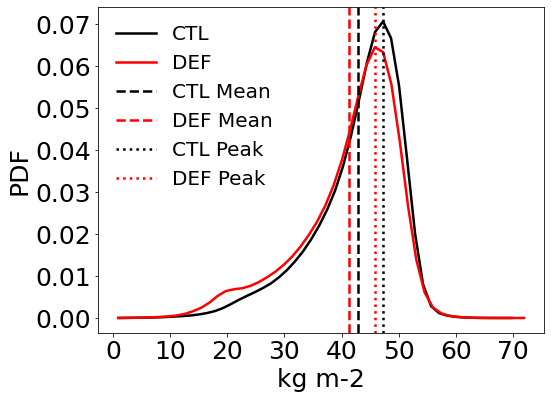

Mean Shift: -1.4646186828613281
Peak Shift: -1.4346504211425781


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate example data
np.random.seed(0)
data_ctl = prw_ctl_mask_f
data_def = prw_def_mask_f

# Calculate PDFs
pdf_ctl, bins_ctl = np.histogram(data_ctl, bins=50, density=True)
pdf_def, bins_def = np.histogram(data_def, bins=50, density=True)

# Calculate the bin centers
bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2
bin_centers_def = (bins_def[:-1] + bins_def[1:]) / 2

# Plot PDFs
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_ctl, pdf_ctl, label='CTL', color='black', linewidth=2.5)
plt.plot(bin_centers_def, pdf_def, label='DEF', color='red', linewidth=2.5)

# Calculate and plot mean shift
mean_shift = np.mean(data_def) - np.mean(data_ctl)
plt.axvline(np.mean(data_ctl), color='black', linestyle='--', label='CTL Mean', linewidth=2.5)
plt.axvline(np.mean(data_def), color='red', linestyle='--', label='DEF Mean', linewidth=2.5)
#plt.text(np.mean(data_def), max(pdf_def), f'Mean Shift: {mean_shift:.2f}', color='blue')

# Calculate and plot peak shift
peak_shift = bin_centers_def[np.argmax(pdf_def)] - bin_centers_ctl[np.argmax(pdf_ctl)]
plt.axvline(bin_centers_ctl[np.argmax(pdf_ctl)], color='black', linestyle=':', label='CTL Peak', linewidth=2.5)
plt.axvline(bin_centers_def[np.argmax(pdf_def)], color='red', linestyle=':', label='DEF Peak', linewidth=2.5)
#plt.text(bin_centers_def[np.argmax(pdf_def)], max(pdf_def), f'Peak Shift: {peak_shift:.2f}', color='blue')

# Customize plot
plt.xlabel('kg m-2', fontsize=25)
plt.ylabel('PDF', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20, frameon=False)
#plt.title('PDF Shift Analysis', fontsize=18)
#plt.grid(True)

# Show plot
plt.show()

# Print shifts
print(f'Mean Shift: {mean_shift}')
print(f'Peak Shift: {peak_shift}')


In [36]:
print(prw_ctl_mask_f_q99, prw_def_mask_f_q99)

54.4338264465332 54.540584564208984


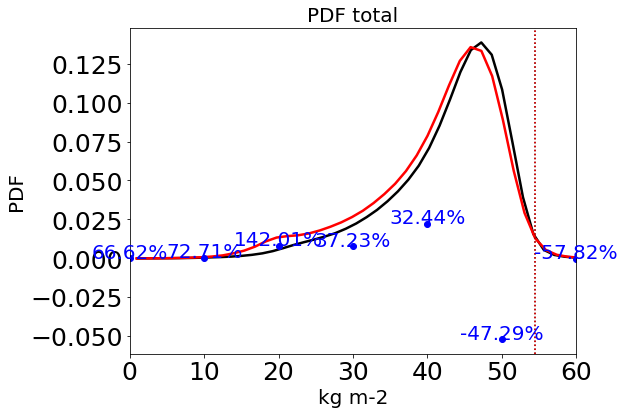

In [18]:
plot_pdf(prw_ctl_mask_f, prw_def_mask_f, 50, 'ctl', 'def', 'black', 'red', 'PDF total', 'kg m-2', 0, 60, prw_ctl_mask_f_q99, prw_def_mask_f_q99)

In [26]:
print(np.shape(prw_ctl_mask_f), np.shape(prw_def_mask_f))

(919662198,) (919662198,)


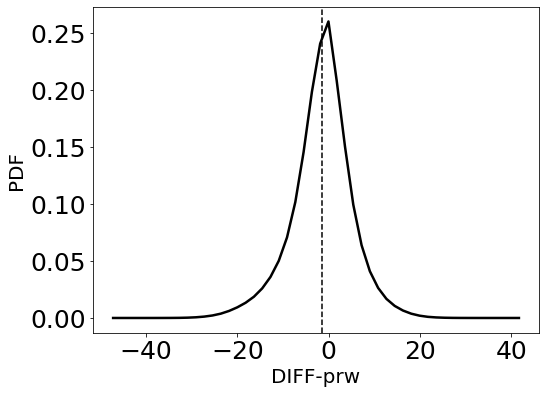

In [29]:
pdf_ctl, bins_ctl = np.histogram(prw_def_mask_f - prw_ctl_mask_f, bins=50, density=True)  # Adjust the number of bins as needed

# Calculate the bin centers
bin_centers_ctl = (bins_ctl[:-1] + bins_ctl[1:]) / 2

# Calculate the bin width
bin_width_ctl = np.diff(bins_ctl)

# Normalize the PDF
pdf_normalized_ctl = pdf_ctl / pdf_ctl.sum()*bin_width_ctl

# Plot the PDF
fig = plt.figure(figsize=(8, 6))
plt.plot(bin_centers_ctl, pdf_normalized_ctl, label='CTL', color='black', linewidth=2.5)


# Set labels and title
plt.xlabel('DIFF-prw', fontsize='20')
plt.ylabel('PDF', fontsize='20')
#plt.title(title, fontsize='20')
#plt.yscale('log')
#plt.xlim(xmin, xmax)

# plot p99
#plt.axvline(p99_1, color='black', ls=':')
#plt.axvline(p99_2, color='red', ls=':')
plt.axvline(np.mean(prw_def_mask_f - prw_ctl_mask_f), color='black', linestyle='--', label='Diff Mean')

plt.xticks(fontsize=25,rotation=0)
plt.yticks(fontsize=25)

# add legend
#plt.legend(fontsize=20)

# Display the plot
plt.show()

# PDF for rainy and non-rainy days

### select the rainy days

In [29]:
# hourly, all years and each month
 
xarray_names = ['pr_ctl_hour_mask','pr_def_hour_mask']

suffix = '_above1'

for name in xarray_names:
    dset_name = name 
    xarray_data = globals()[dset_name] * 3600 # mm/hour
    xarray_data_abov1 = xarray_data > 0.1 # only select the data above 0.1mm/hour -> 0 or 1
    
    new_name = dset_name + suffix
    globals()[new_name] = xarray_data_abov1

In [30]:
# replace the 0 with nan
ctl_rainy = pr_ctl_hour_mask_above1.where(pr_ctl_hour_mask_above1 != 0)
def_rainy = pr_def_hour_mask_above1.where(pr_def_hour_mask_above1 != 0)

In [31]:
# Masking non-rainy days
is_rainy_day_ctl = ctl_rainy.resample(time='1D').max(dim='time')
is_rainy_day_def = def_rainy.resample(time='1D').max(dim='time')

In [33]:
# broadcast the daily mask to hourly resolution
hourly_ctl_mask_rainy = is_rainy_day_ctl.reindex(time=prw_ctl_mask['time'], method='ffill')
hourly_def_mask_rainy = is_rainy_day_def.reindex(time=prw_def_mask['time'], method='ffill')

In [34]:
# save the prw only on rainy days
prw_rainy_ctl = prw_ctl_mask.where(hourly_ctl_mask_rainy == 1)
prw_rainy_def = prw_def_mask.where(hourly_def_mask_rainy == 1)

In [35]:
# save the prw only on non-rainy days
prw_nonrainy_ctl = prw_ctl_mask.where(hourly_ctl_mask_rainy != 1)
prw_nonrainy_def = prw_def_mask.where(hourly_def_mask_rainy != 1)

_rainy days_

In [38]:
xarray_names = ['prw_rainy_ctl','prw_rainy_def']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/m/m300948/.conda/envs/JUPYTER_MODULE/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepd

In [39]:
# year/month separation
new_suffix = '_q99'
xarray_names = ['prw_rainy_ctl','prw_rainy_def']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

_non-rainy days_

In [41]:
xarray_names = ['prw_nonrainy_ctl','prw_nonrainy_def']
new_suffix = '_f'

for name in xarray_names:
    xarray_data = globals()[name]
    xarray_data_flat = xarray_data.values.flatten()
    xarray_data_f = xarray_data_flat[~np.isnan(xarray_data_flat)]
    new_name = name + new_suffix
    globals()[new_name] = xarray_data_f

: 

: 

In [ ]:
# year/month separation
new_suffix = '_q99'
xarray_names = ['prw_nonrainy_ctl','prw_nonrainy_def']

for name in xarray_names:
    dset_name = name + '_f' 
    xarray_data = globals()[dset_name]
    xarray_data_q99 = np.nanquantile(xarray_data, 0.99, axis=0)

    new_name = dset_name + new_suffix
    globals()[new_name] = xarray_data_q99

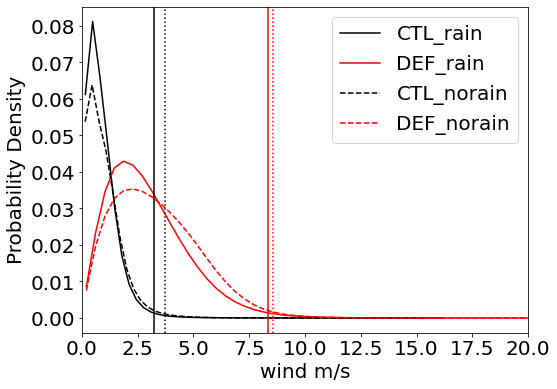

: 

In [ ]:
pdf_rainy_ctl, bins_rainy_ctl = np.histogram(prw_rainy_ctl_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_rainy_def, bins_rainy_def = np.histogram(prw_rainy_def_f, bins=50, density=True)
pdf_nonrainy_ctl, bins_nonrainy_ctl = np.histogram(prw_nonrainy_ctl_f, bins=50, density=True)  # Adjust the number of bins as needed
pdf_nonrainy_def, bins_nonrainy_def = np.histogram(prw_nonrainy_def_f, bins=50, density=True)

# Calculate the bin centers
bin_centers_rainy_ctl = (bins_rainy_ctl[:-1] + bins_rainy_ctl[1:]) / 2
bin_centers_rainy_def = (bins_rainy_def[:-1] + bins_rainy_def[1:]) / 2
bin_centers_nonrainy_ctl = (bins_nonrainy_ctl[:-1] + bins_nonrainy_ctl[1:]) / 2
bin_centers_nonrainy_def = (bins_nonrainy_def[:-1] + bins_nonrainy_def[1:]) / 2

# Calculate the bin width
bin_width_rainy_ctl = np.diff(bins_rainy_ctl)
bin_width_rainy_def = np.diff(bins_rainy_def)
bin_width_nonrainy_ctl = np.diff(bins_nonrainy_ctl)
bin_width_nonrainy_def = np.diff(bins_nonrainy_def)

# Normalize the PDF
pdf_normalized_rainy_ctl = pdf_rainy_ctl / pdf_rainy_ctl.sum()*bin_width_rainy_ctl
pdf_normalized_rainy_def = pdf_rainy_def / pdf_rainy_def.sum()*bin_width_rainy_def
pdf_normalized_nonrainy_ctl = pdf_nonrainy_ctl / pdf_nonrainy_ctl.sum()*bin_width_nonrainy_ctl
pdf_normalized_nonrainy_def = pdf_nonrainy_def / pdf_nonrainy_def.sum()*bin_width_nonrainy_def

# Plot the PDF
fig = plt.figure(figsize=(8, 6))
plt.plot(bin_centers_rainy_ctl, pdf_normalized_rainy_ctl, label='CTL_rain', color='black')
plt.plot(bin_centers_rainy_def, pdf_normalized_rainy_def, label='DEF_rain', color='red')
plt.plot(bin_centers_nonrainy_ctl, pdf_normalized_nonrainy_ctl, label='CTL_norain', color='black', linestyle='--')
plt.plot(bin_centers_nonrainy_def, pdf_normalized_nonrainy_def, label='DEF_norain', color='red', linestyle='--')

# Set labels and title
plt.xlabel('prw m/s', fontsize='20')
plt.ylabel('Probability Density', fontsize='20')
#plt.title(title, fontsize='20')
#plt.yscale('log')
plt.xlim(0, 20)

# plot p99
plt.axvline(prw_rainy_ctl_f_q99, color='black')
plt.axvline(prw_rainy_def_f_q99, color='red')
plt.axvline(prw_nonrainy_ctl_f_q99, color='black', ls=':')
plt.axvline(prw_nonrainy_def_f_q99, color='red', ls=':')

plt.xticks(fontsize=20,rotation=0)
plt.yticks(fontsize=20)

# add legend
plt.legend(fontsize=20)

# Display the plot
plt.show()